# QC analysis for TCGA genotype
## Convert TCGA Birdseed to VCF

In [1]:
# import seaborn as sns
import glob,os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tabix
import seaborn as sns
from intervaltree import Interval, IntervalTree
import re

plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
raw_path = '/hpc/grid/wip_drm_targetsciences/projects/TCGA/'
# path = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor'
path = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor'
QC_path = path + '/f02_QC/plink1'
work_path = path + '/p09_cyto_norm_2step_peer_qtl'

snp_array_path = raw_path + '/SNP-Array'
magetab_path = snp_array_path + '/MAGETAB'
sdrf = glob.glob(magetab_path + '/broad*/*.sdrf.txt')
meta_data = path + '/meta.tsv'
vcf_flist_fn = path + '/f01_birdseed_vcf_file_list/birdseed_vcf_files.txt'
discordant_sample_fn = path + '/f01_birdseed_vcf_file_list/replicate_discordant.txt'

anno_path = '/hpc/grid/wip_drm_targetsciences/projects/TCGA/SNP-Array/IMPUTE/vep_anno_vcf'
anno_vcfs = glob.glob(anno_path + '/*.tsv.gz')
tabix_dict = {}  # {chr:tabix_obj}
for anno in anno_vcfs:
    chrom = anno.split('/')[-1].split('.')[0]
    tabix_dict[chrom] = tabix.open(anno)

In [2]:
def kg_race(race):
    # add race to meta data
    if race in ['CHB','JPT','CHS','CDX','KHV']:
        return 'EAS'
    elif race in ['CEU','TSI','FIN','GBR','IBS']:
        return 'EUR'
    elif race in ['YRI','LWK','GWD','MSL','ESN','ASW','ACB']:
        return 'AFR'
    elif race in ['MXL','PUR','CLM','PEL']:
        return 'AMR'
    elif race in ['GIH','PJL','BEB','STU','ITU']:
        return 'SAS'
    else:
        return 'other'
    
def add_race2tcga(race):
    '''add ethnicity'''
    if race == 'WHITE':
        return 'EUR'
    elif race == 'BLACK OR AFRICAN AMERICAN':
        return 'AFR'
    elif race == 'ASIAN':
        return 'EAS'
    elif race == 'AMERICAN INDIAN OR ALASKA NATIVE':
        return 'AMR'
    else:
        return 'other'

In [3]:
# build dictionary {patient barcode: gender}
meta_df = pd.read_csv(meta_data,header=0, sep='\t')
meta_df['tcga_eth'] = meta_df['race'].map(lambda x: add_race2tcga(x))
tcga_race_dict = meta_df.set_index('bcr_patient_barcode')['tcga_eth'].to_dict()
patients = meta_df['bcr_patient_barcode'].tolist()
patient_sex_dict = meta_df.set_index('bcr_patient_barcode')['gender'].to_dict()
print('there are', len(patient_sex_dict),'patients have annotations in tcga')
print(meta_df['tcga_eth'].value_counts())

there are 11160 patients have annotations in tcga
EUR      8186
other    1338
AFR       934
EAS       675
AMR        27
Name: tcga_eth, dtype: int64


In [5]:
# get birdseed files that are not in the metadata file
# fn_sample_dict:  {birdseed file : tcga sample barcode id}
# sample_fn_dict: {tcga sample barcode id: birdseed file}
not_in_seed = snp_array_path + '/array_with_no_meta.txt'
fn_sample_dict = {}
sample_fn_dict = {}
sample_ctype_dict = {}
partic_ctype_dict = {}
with open(not_in_seed,'w') as out_h:
    for sd in sdrf:
        try:
            df = pd.read_csv(sd,sep='\t',header=0,encoding='latin1')
            dic = df.set_index('Derived Array Data Matrix File.1')\
                      ['Comment [TCGA Barcode]'].to_dict()
            fn_sample_dict.update(dic)
            dic = df.set_index('Comment [TCGA Barcode]') \
                      ['Derived Array Data Matrix File.1'].to_dict()
            sample_fn_dict.update(dic)
            
            birdseed_samples = df['Comment [TCGA Barcode]'].tolist()
            birdseed_samples = ['-'.join(s.split('-')[:3]) for s in birdseed_samples]
            non_overlap_samples = set(birdseed_samples) - set(sample_fn_dict.keys())
            for birdseed_fn in df['Derived Array Data Matrix File.1']:
                s = '-'.join(fn_sample_dict[birdseed_fn].split('-')[:3])
                if s in non_overlap_samples:
                    out_h.write('\t'.join([s, birdseed_fn,  \
                            sd.split('/')[-1]])+'\n')
            # {sample:cancer type}
            ctype = sd.split('/')[-1].split('.')[2][4:]
            for k in sample_fn_dict:
                if k not in sample_ctype_dict:
                    sample_ctype_dict[k] = ctype
                    partic_ctype_dict['-'.join(k.split('-')[:3])]=ctype
        except:
            print(sd)
            assert False

In [6]:
# prepare gender and phenotype file for plink to incorporate
gender_fn = QC_path + '/gender.txt'
pheno_fn = QC_path + '/pheno.txt'
with open(gender_fn, 'w') as gender, open(pheno_fn, 'w') as pheno:
    gender.write('\t'.join(['#FID','IID','SEX']) + '\n')
    pheno.write('\t'.join(['#FID','IID','pheno']) + '\n')
    for k,v in sample_fn_dict.items():
        patient = '-'.join(k.split('-')[:3])
        if patient in patient_sex_dict:
            sex = patient_sex_dict[patient]
        else:
            sex = '0'
        if sex == 'MALE':
            sex = '1'
        elif sex == 'FEMALE':
            sex = '2'
        gender.write('\t'.join([k, k, sex])+'\n')
        # get phenotype tissue id
        tissue = int(k.split('-')[3][:-1])
        if tissue > 9:
            p = '1'
        else:
            p = '2'
        pheno.write('\t'.join([k,k,p])+'\n')

## Decide normal samples to includ in the downstream analysis
For participants with more than 1 normal samples, we calculate the discordance scores between replicate samples, samples with more than 0.2 were removed

In [7]:
# check raw samles first
raw_fam_fn = QC_path + '/tcga_raw.fam'
raw_fam_df = pd.read_csv(raw_fam_fn, sep=' ',header=None)
raw_fam_df['FID'] = raw_fam_df[1].map(lambda x: '-'.join(x.split('-')[:3]))
raw_with_snps = raw_fam_df['FID'].unique().tolist()
raw_fam_df['normal'] = raw_fam_df[1].map(lambda x: 'Y' if int(x.split('-')[3][:-1]) > 9
                                        else 'N')
print(len(raw_with_snps), 'participants have snp arrays')
meta_df.query('bcr_patient_barcode in @raw_with_snps')['tcga_eth'].value_counts()

11127 participants have snp arrays


EUR      8118
other    1328
AFR       923
EAS       672
AMR        27
Name: tcga_eth, dtype: int64

In [8]:
# extract normal samples
normal_df = raw_fam_df.query('normal == "Y"')
normP_sample_dict = {k:list(v) for k,v in normal_df.groupby('FID')[1]}
print(len(normP_sample_dict),'participants have normal samples')
norm_ppl = list(normP_sample_dict.keys())
display(meta_df.query('bcr_patient_barcode in @norm_ppl')['tcga_eth'].value_counts())

ppl_with_many_norm_samples = []
for k,v in normP_sample_dict.items():
    if len(v) > 1:
        ppl_with_many_norm_samples.append(k)
print(len(ppl_with_many_norm_samples),'individuals have replicate normal samples')

10879 participants have normal samples


EUR      7970
other    1265
AFR       909
EAS       661
AMR        25
Name: tcga_eth, dtype: int64

623 individuals have replicate normal samples


## For samples with replicates, get the sample with higher call rate

In [448]:
# # build {tcga patient barcode id: [tcga sample barcode id]}
# patient_sample_dict = {}
# for k,v in sample_fn_dict.items():
#     p = '-'.join(k.split('-')[:3])
#     if p in patient_sample_dict:
#         patient_sample_dict[p].append(k)
#     else:
#         patient_sample_dict[p] = [k]
    
# # check duplicate discordance
# vcf_flist_df = pd.read_csv(vcf_flist_fn,header=None,names=['file'])
# vcf_flist_df['IID'] = vcf_flist_df['file'].map(lambda x: 
#                             x.split('/')[-1].split('.')[0])
# sample_vcf_dict = vcf_flist_df.set_index('IID')['file'].to_dict()
# normP_sample_dict = {}
# for k,v in sample_vcf_dict.items():
#     p = '-'.join(k.split('-')[:3])
#     if int(k.split('-')[3][:-1]) > 9:
#         if p in normP_sample_dict:
#             normP_sample_dict[p].append(k)
#         else:
#             normP_sample_dict[p] = [k]
# print('there are',len(normP_sample_dict),'individule have normal sample')
# print('race distribution is:')

In [76]:
# # --------- get replicate discordant samples, process take a long time
# with open(discordant_sample_fn,'w') as out:
#     dsct_samples = []
#     for k,v in normP_sample_dict.items():
#         vcfs = ' '.join([sample_vcf_dict[f] for f in v if f in sample_vcf_dict])
#         if len(v) > 1:    
#             # merge vcf files

#             cmd = ('bcftools merge -O z -o merge.vcf.gz {vcfs}').format(vcfs=vcfs)
#             os.system(cmd)
#             cmd = 'bcftools gtcheck merge.vcf.gz'
#             check = os.popen(cmd).read()
#             for line in check.split('\n'):
#                 if line.startswith('ERR'):
#                     err = float(line.split('\t')[1])
#                     if err > 0.02:
#                         out.write(line + '\n')
#             os.remove('merge.vcf.gz')            

In [9]:
discordant_df = pd.read_csv(discordant_sample_fn,sep='\t',header=None)
discordant_df['p'] = discordant_df[3].map(lambda x: '-'.join(x.split('-')[:3]))
discordant_id = discordant_df[discordant_df[1].values > 0.02]['p'].unique().tolist()
# for i in discordant_id:
#     try:
#         del normP_sample_dict[i]
#     except:
#         pass
print('there are',len(discordant_id),'participants with discordant samples')

there are 72 participants with discordant samples


In [10]:
# get miss score
imiss_fn = QC_path  +'/f01_missing/tcga_raw_miss.imiss'
imiss_df = pd.read_csv(imiss_fn, delim_whitespace=True,header=0)
imiss_df['FID'] = imiss_df['IID'].map(lambda x: '-'.join(x.split('-')[:3]))
miss_dict = imiss_df.set_index('IID')['F_MISS'].to_dict()
for k,v in normP_sample_dict.items():
    if len(v) > 1:
        miss_rate = [miss_dict[i] for i in v]
        min_miss_index = miss_rate.index(min(miss_rate))
        normP_sample_dict[k] = [v[min_miss_index]]

study_sample = [v[0] + '\t' + v[0] for k,v in normP_sample_dict.items()]
study_sample = [s for s in study_sample if '-'.join(s.split('-')[:3]) not in discordant_id]
with open(QC_path + '/study_samples.txt', 'w') as out:
    out.write('\n'.join(study_sample) + '\n')
print('there are ',len(study_sample), 'people to study')
study_people = ['-'.join(s.split('-')[:3]) for s in study_sample]

there are  10807 people to study


## Check heterozygosity and missingness

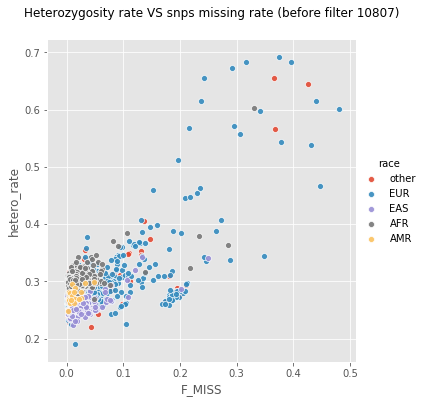

In [36]:
import numpy as np
het_fn = QC_path + '/f01_missing/tcga_het.het'
het_df = pd.read_csv(het_fn,header=0, delim_whitespace=True)
het_df['hetero_rate'] = (het_df['N(NM)'] - het_df['O(HOM)']) /  het_df['N(NM)']
het_df['p'] = het_df['IID'].map(lambda x: '-'.join(x.split('-')[:3]))
het_df['race'] = het_df['p'].map(lambda x:tcga_race_dict[x] if x in tcga_race_dict else 'other')
miss_fn = QC_path + '//f01_missing/tcga_miss.imiss'
miss_df = pd.read_csv(miss_fn,header=0, delim_whitespace=True)
het_miss_df = pd.merge(het_df[['IID','hetero_rate','p','race']],miss_df[['IID','F_MISS']], \
                       on='IID')
# het_miss_df['p'] = het_miss_df['IID'].map(lambda x: '-'.join(x.split('-')[:3]))
# het_miss_df['race'] = het_miss_df['p'].map(lambda x:race_dict[x] if x in race_dict else 'other')
# het_miss_df['F_MISS'] =  np.log(het_miss_df['F_MISS'])
race = ['other','EUR','EAS','AFR','AMR']
g = sns.pairplot(x_vars=['F_MISS'],y_vars=['hetero_rate'],data=het_miss_df,
                 hue='race',hue_order=race,height=5,
                plot_kws={'alpha':0.9})
_ = g.fig.suptitle('Heterozygosity rate VS snps missing rate (before filter)',y=1.08)

In [37]:
def filter_het(row,mean_dict,std_dict):
    mean = mean_dict[row['race']]
    std = std_dict[row['race']]
    lo_het = mean - 3 * std
    hi_het = mean + 3 * std
    if lo_het <= row['hetero_rate'] <= hi_het:
        return 'Y'
    else:
        return 'N'
race_het_mean_dict = {}
race_het_std_dict = {}
for r in race:
    mean = het_miss_df.query('race ==@r')['hetero_rate'].mean()
    std = het_miss_df.query('race ==@r')['hetero_rate'].std()
    race_het_mean_dict[r] = mean
    race_het_std_dict[r] = std
het_miss_df['miss_pass'] = het_miss_df['F_MISS'].map(lambda x: 'Y' if x <=0.05 else 'N')
het_miss_df['het_pass'] = het_miss_df.apply(lambda row:
                        filter_het(row,race_het_mean_dict,race_het_std_dict),axis=1)
filter_het_miss_samples = het_miss_df.query('het_pass == "Y" & miss_pass == "Y"')\
                                                          ['IID'].tolist()
filter_het_miss_people = ['-'.join(x.split('-')[:3]) for x in filter_het_miss_samples]
print('missing and heterozygosity count')
print(pd.crosstab(het_miss_df['het_pass'], het_miss_df['miss_pass']))
# print('there are',len(filter_het_samples),'pass the heterozygosity')
print(len(filter_het_miss_people),
    'samples after filter low call rate and heterozygosity')
print(meta_df.query('bcr_patient_barcode in @filter_het_miss_people' )\
      ['tcga_eth'].value_counts())
with open(QC_path+'/f01_missing/highCallRateHet_sample.txt', 'w') as out:
    out.write('\n'.join([p+' '+p for p in filter_het_miss_samples])+'\n')

missing and heterozygosity count
miss_pass    N      Y
het_pass             
N           80     12
Y          221  10494
10494 samples after filter low call rate and heterozygosity
EUR      7675
other    1224
AFR       884
EAS       639
AMR        25
Name: tcga_eth, dtype: int64


In [488]:
# high_call_rate_fn = QC_path + '/f01_missing/highCallRate_sample.txt'
# high_call_rate_df = pd.read_csv(high_call_rate_fn,header=None,delim_whitespace=True)
# high_call_rate_samples = high_call_rate_df[1].tolist()
# high_call_rate_het_df = high_call_rate_df[high_call_rate_df[0]\
#                         .isin(filter_het_samples)]
# high_call_rate_het_samples = high_call_rate_het_df[0].tolist()
# high_call_rate_het_people = ['-'.join(x.split('-')[:3]) for x in high_call_rate_het_samples]
# print(high_call_rate_het_df.shape[0],
#     'samples after filter low call rate and heterozygosity')
# high_call_rate_het_df.to_csv(path + '/f02_QC/plink1/f01_missing/highCallRateHet_sample.txt',
#                             sep=' ',index=False,header=None)
# meta_df.query('bcr_patient_barcode in @high_call_rate_het_people' )['eth'].value_counts()

Text(0.5, 1.08, 'Heterozygosity rate VS snps missing rate (after filtering)')

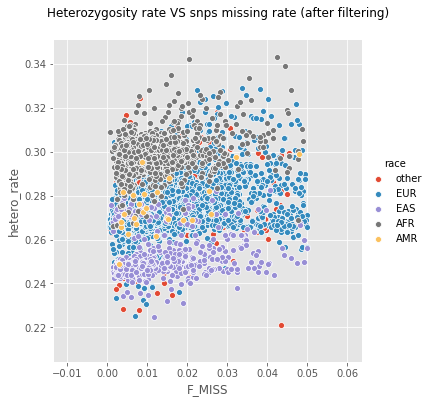

In [38]:
filter_het_miss_df = het_miss_df.query('IID in @filter_het_miss_samples')
g = sns.pairplot(x_vars=['F_MISS'],y_vars=['hetero_rate'],data=filter_het_miss_df,
                 hue='race',hue_order=['other','EUR','EAS','AFR','AMR'],height=5)
g.fig.suptitle('Heterozygosity rate VS snps missing rate (after filtering)',y=1.08)

## Sex check

In [39]:
# sex check
sex_fn = QC_path + '/f02_checksex/tcga_rmSp_rmSNP_sexcheck.sexcheck'
sex_df = pd.read_csv(sex_fn,header=0, delim_whitespace=True)
sex_df['STATUS'] = sex_df.apply(lambda x: 'OK' if x['PEDSEX']==0 else x['STATUS'],axis=1)
sex_df['FID'] = sex_df['FID'].map(lambda x: '-'.join(x.split('-')[:3]))
print('there are',sex_df['FID'].unique().shape[0],'patients have SNP array data',
     'with total of',sex_df.shape[0],'SNP arrays')
# build sex patient sample dictionary
sex_patients = sex_df['FID'].unique().tolist()
sex_patient_sample_dict = {k:list(v) for k,v in sex_df.groupby('FID')['IID']}
patientsWithArrayButNoAnno = set(set(sex_df['FID'].tolist() - patient_sex_dict.keys()))
patientsWithAnnoButNoArray = set(patient_sex_dict.keys()) - set(sex_df['FID'].tolist())
print(len(patientsWithArrayButNoAnno),'of tcga with array do not have annotation')
print(len(patientsWithAnnoButNoArray),'of tcga annotated samples do not have array')
print(sex_df['FID'].unique().shape[0] - len(patientsWithArrayButNoAnno),
     'of tcga with array and annotatoin')
print(sex_df.query('STATUS == "OK"').shape[0],'sampels pass the sex check')

there are 10494 patients have SNP array data with total of 10494 SNP arrays
47 of tcga with array do not have annotation
713 of tcga annotated samples do not have array
10447 of tcga with array and annotatoin
10458 sampels pass the sex check


In [333]:
# one_array_norm_pp,one_array_case_pp,multi_norm_only_pp,multi_case_only_pp \
#  = getPatientWithOneSampleOrOneType(sex_patient_sample_dict)
# print(len(one_array_norm_pp),'people with only one normal tissue')
# print(len(one_array_case_pp),'people with only one tumor tissue')
# print(len(multi_norm_only_pp),'people with multiple only norm_sp')
# print(len(multi_case_only_pp),'people with multiple only case_sp')

# # check number of people with normal samples
# sex_df['have_anno'] = sex_df['FID'].map(lambda x: 'Y' if x in patient_sex_dict else 'N')
# sex_df['have_normal'] = sex_df['FID'].map(lambda x: 'Y' if x not in \
#                             one_array_case_pp + multi_case_only_pp else 'N')
# sex_df['have_case'] = sex_df['FID'].map(lambda x: 'Y' if x not in \
#                             one_array_norm_pp + multi_norm_only_pp else 'N')
# sex_df['normal'] = sex_df['IID'].map(lambda x:'Y' if int(x.split('-')[3][:-1])>9 else 'N')
# print(sex_df.query('have_normal == "Y" & have_case == "Y"')['FID'].unique().shape[0],
#      'people with both normal and case sample')
# print(sex_df.query('STATUS =="OK"')['FID'].unique().shape[0],'people have samples \
#      pass the sex check')

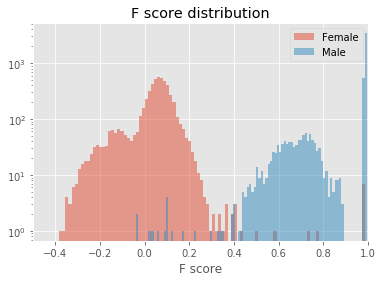

In [45]:
# sex check, plot their F scores for all normal samples and tumor only samples
plt.hist(sex_df.query('PEDSEX == 2')['F'], bins=100,label='Female',alpha=0.5)
plt.hist(sex_df.query('PEDSEX == 1')['F'], bins=100,label='Male',alpha=0.5)
plt.title('F score distribution')
plt.yscale('log')
plt.xlim([-0.5,1])
plt.xlabel('F score')
plt.legend()
# plt.savefig(work_path + '/sex_check.png',ppi=300)

In [46]:
# check how many europeans are there in the 10458 samples
sex_ppl = sex_df.query('STATUS == "OK"')['FID'].tolist()
print(meta_df.query('bcr_patient_barcode in @sex_ppl')['tcga_eth'].value_counts())
with open(QC_path + '/f02_checksex/keep_sex.txt','w') as out:
    iids = [p+' '+p for p in sex_df.query('STATUS=="OK"')['IID'].tolist()]
    out.write('\n'.join(iids)+'\n')

EUR      7650
other    1216
AFR       883
EAS       638
AMR        24
Name: tcga_eth, dtype: int64


## Check race

In [47]:
# 1kg meta data
kg1_pheno_fn = QC_path + '/20130606_g1k.ped'
kg1_df = pd.read_csv(kg1_pheno_fn, sep='\t',header=0)
kg1_df['kg1_eth'] = kg1_df['Population'].map(lambda x: kg_race(x))
# kg1_df.to_csv(kg1_pheno_fn,sep='\t',index=False)
# build kg1 sample and eth dict
kg1_sp_race_dict = kg1_df.set_index('Individual ID')['kg1_eth'].to_dict()
kg1_pca_fn = QC_path + '/f04_pca/pcs_1kg'
kg1_pca_df = pd.read_csv(kg1_pca_fn,sep='\t',header=0)
kg1_pca_df['kg1_eth'] = kg1_pca_df['IID'].map(lambda x:kg1_sp_race_dict[x])
kg1_pca_df.to_csv(kg1_pca_fn,sep='\t',index=False)

In [48]:
# tcga
tcga_sp_race_dict = meta_df.set_index('bcr_patient_barcode')['tcga_eth'].to_dict()
tcga_pca_fn = QC_path + '/f04_pca/tcga_projections.txt'
tcga_pca_df = pd.read_csv(tcga_pca_fn, sep='\t',header=0)
tcga_pca_df['person'] = tcga_pca_df['IID'].map(lambda x: '-'.join(x.split('-')[:3]))
tcga_pca_df['tcga_eth'] = tcga_pca_df['person'].map(lambda x: tcga_sp_race_dict[x] \
                                            if x in tcga_sp_race_dict else 'unknown')
print(tcga_pca_df.shape)
tcga_pca_df['tcga_eth'].value_counts()
# here unknown means the meta data is not available for those patients

(10458, 14)


EUR        7650
other      1216
AFR         883
EAS         638
unknown      47
AMR          24
Name: tcga_eth, dtype: int64

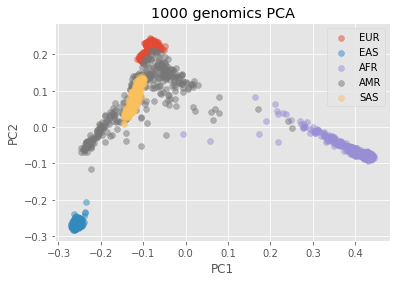

In [50]:
plt.figure()
race = ['EUR', 'EAS', 'AFR', 'AMR', 'SAS']
for r in race:
    sub_df = kg1_pca_df.query('kg1_eth == @r')
    plt.scatter(sub_df['PC1'],sub_df['PC2'],label=r, alpha=.5)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
plt.title('1000 genomics PCA')
plt.legend()
# plt.savefig(work_path + '/kg1_pca.png',ppi=300)

In [50]:
# import seaborn as sns
# race = ['EUR','EAS','AFR','AMR','SAS']
# g = sns.pairplot(x_vars=['PC1'],y_vars=['PC2'],data=kg1_pca_df,
#                  hue='eth',hue_order=race,height=5,markers=['o','+','s','D','h'],
#                 plot_kws={'alpha':0.9})
# _ = g.fig.suptitle('1000 genomics PCA',y=1.08)

In [573]:
# # plot
# import matplotlib.pyplot as plt
# plt.style.use('ggplot')
# groups = kg1_pca_df.groupby('eth')
# fig, ax = plt.subplots()
# for name, group in groups:
#     ax.plot(group.PC1, group.PC2,marker='o',linestyle='',ms=12,label=name,alpha=0.5)
# ax.legend()
# ax.set_title('1kg PCA')
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')

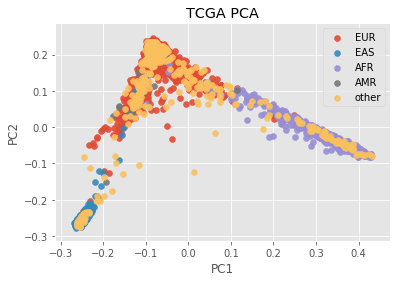

In [51]:
plt.figure()
race = ['EUR', 'EAS', 'AFR', 'AMR', 'other']
for r in race:
    sub_df = tcga_pca_df.query('tcga_eth == @r')
    plt.scatter(sub_df['PC1'],sub_df['PC2'],label=r,alpha=.9)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
plt.title('TCGA PCA')
plt.legend()

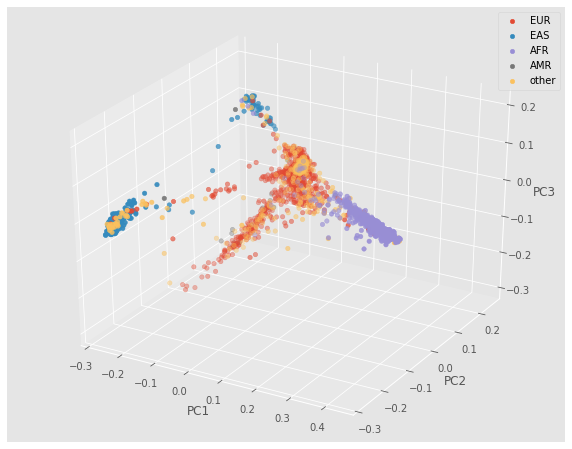

In [62]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
threedee = plt.figure(figsize=(10,8)).gca(projection='3d')
race = ['EUR', 'EAS', 'AFR', 'AMR', 'other']
color = ['grey','red','gree','yellow','blue']
for r, c in zip(race,color):
    sub_df = tcga_pca_df.query('tcga_eth == @r')
    threedee.scatter(sub_df['PC1'],sub_df['PC2'],sub_df['PC3'],label=r, cmap=matplotlib.colors.ListedColormap(c))
    threedee.set_xlabel('PC1')
    threedee.set_ylabel('PC2')
    threedee.set_zlabel('PC3')
plt.legend()

In [47]:
# race = ['EUR','EAS','AFR','AMR','other']
# g = sns.pairplot(x_vars=['PC1'],y_vars=['PC2'],data=tcga_pca_df,
#                  hue='eth',hue_order=race,height=5,markers=['o','+','s','D','h'],
#                 plot_kws={'alpha':0.9})
# _ = g.fig.suptitle('tcga PCA',y=1.08)

## predict tcga race
Use mean +- 6sd

In [57]:
races = ['EUR','EAS','AFR','AMR','SAS']
means = {}
stds = {}
for r in races:
    mean = kg1_pca_df.iloc[:,2:].query('kg1_eth == @r').mean()
    std = kg1_pca_df.iloc[:,2:].query('kg1_eth == @r').std()
    means[r] = mean
    stds[r] = std
# print(mean + 6*std, mean - 6 *std)

In [79]:
def predict_tcga_ace(row, means, stds, n):
    '''
    n is number of PC to include
    '''
    races = ['EUR','EAS','AFR','AMR','SAS']
    res = []
    for r in races:
        is_race = True
        for i in range(n):
            pc = 'PC' + str(i+1)
            up = means[r][pc] + 6 * stds[r][pc]
            lo = means[r][pc] - 6 * stds[r][pc]
            if not (row[pc] >= lo and float(row[pc]) <= up):
                is_race = False
                break
            else:
                continue
        if is_race:
            res.append(r)
    if res == []:
        return 'other'
    else:
        return res[0]
        if res[0] == 'EUR':
            return 'EUR'
        else:
            return 'other'

tcga_pca_df['tcga_pred'] = tcga_pca_df.apply(lambda row:\
               predict_tcga_ace(row,means,stds,10),axis=1)
# tcga_pca_df.query('tcga_pred == "EUR"').shape

In [80]:
pd.crosstab(tcga_pca_df.tcga_eth, tcga_pca_df.tcga_pred)

tcga_pred,AFR,AMR,EAS,EUR,SAS,other
tcga_eth,,,,,,
AFR,831,37,0,11,0,4
AMR,0,17,1,6,0,0
EAS,0,54,571,6,1,6
EUR,27,400,8,7207,0,8
other,65,143,25,978,0,5
unknown,2,6,6,33,0,0


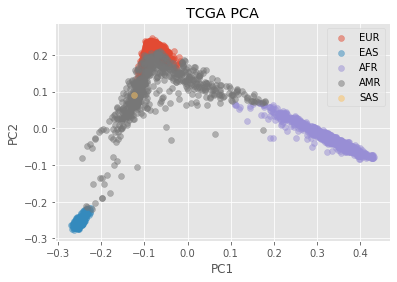

In [83]:
# check the ones are not EUR but predicted as EUR in the pca
plt.figure()
pc_x = 'PC1'
pc_y = 'PC2'
race = ['EUR', 'EAS', 'AFR', 'AMR', 'SAS']
color = ['grey','red','green','yellow','purple']
for r in race:
    sub_df = tcga_pca_df.query('tcga_pred == @r')
    plt.scatter(sub_df['PC1'],sub_df['PC2'],label=r,alpha=.5)
    plt.xlabel(pc_x)
    plt.ylabel(pc_y)
# inconsis_cate = ['AFR','AMR','EAS']
# inconsis_df = tcga_pca_df.query('tcga_pred=="EUR" & tcga_eth in @inconsis_cate')
# plt.scatter(inconsis_df[pc_x],inconsis_df[pc_y],label='inconsis', c='black',alpha=.5)
plt.title('TCGA PCA')
plt.legend()
plt.savefig(work_path + '/tcga_eth.png',ppi=300)

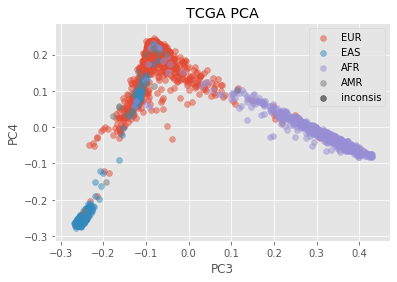

In [24]:
# check the ones are EUR but predicted as not EUR in the pca
plt.figure()
pc_x = 'PC3'
pc_y = 'PC4'
race = ['EUR', 'EAS', 'AFR', 'AMR']
color = ['grey','red','green','yellow','purple']
for r in race:
    sub_df = tcga_pca_df.query('tcga_eth == @r')
    plt.scatter(sub_df['PC1'],sub_df['PC2'],label=r,alpha=.5)
    plt.xlabel(pc_x)
    plt.ylabel(pc_y)
inconsis_cate = ['EUR']
inconsis_df = tcga_pca_df.query('tcga_pred=="other" & tcga_eth in @inconsis_cate')
plt.scatter(inconsis_df[pc_x],inconsis_df[pc_y],label='inconsis', c='black',alpha=.5)
plt.title('TCGA PCA')
plt.legend()

## Check kinship

In [2]:
kinship_fn = QC_path + '/f05_kinship/tcga.qced.kin0'
kinship_df = pd.read_csv(kinship_fn, sep='\t',header=0)
# fail_kinship_samples = kinship_df.query('InfType !="UN"')['ID1'] + \

In [3]:
print('3rd min',kinship_df.query('InfType == "3rd"')['Kinship'].min())
print('4th max',kinship_df.query('InfType == "4th"')['Kinship'].max())
(kinship_df.query('InfType == "4th"')['Kinship'].max() + \
   kinship_df.query('InfType == "3rd"')['Kinship'].min()) / 2

3rd min 0.0242
4th max 0.2037


0.11395

In [6]:
kinship_df.head(n=1)

,FID1,ID1,FID2,ID2,N_SNP,HetHet,IBS0,HetConc,HomIBS0,Kinship,IBD1Seg,IBD2Seg,PropIBD,InfType
0,TCGA-YZ-A982-10A-01D-A39Y-01,TCGA-YZ-A982-10A-01D-A39Y-01,TCGA-DB-5275-10A-01D-1466-01,TCGA-DB-5275-10A-01D-1466-01,775316,0.1166,0.0483,0.2549,0.4233,0.0286,0.0404,0.0,0.0202,UN


In [27]:
fail_kinship_df = kinship_df.query('Kinship > 0.11395')
kinship_pairs = []
for iter, row in fail_kinship_df.iterrows():
    kinship_pairs.append([row['ID1'], row['ID2']])
l = kinship_pairs
out = []
while len(l)>0:
    first, *rest = l
    first = set(first)

    lf = -1
    while len(first)>lf:
        lf = len(first)

        rest2 = []
        for r in rest:
            if len(first.intersection(set(r)))>0:
                first |= set(r)
            else:
                rest2.append(r)     
        rest = rest2

    out.append(first)
    l = rest

In [28]:
remove_kin_samples = [b for a in out for b in list(a)[1:]]
print('remove kinship samples',len(remove_kin_samples))

remove kinship samples 18


In [29]:
kin_filter_df = tcga_pca_df.query('IID not in @remove_kin_samples')
kin_filter_df = kin_filter_df.reset_index(drop=True)
kin_filter_df['FID'] = kin_filter_df['FID'].map(lambda x:'-'.join(x.split('-')[:3]))
kin_keep_samples = kin_filter_df['IID'].tolist()
print(len(kin_keep_samples),'samples pass kinship')

10441 samples pass kinship


In [30]:
pd.crosstab(kin_filter_df.tcga_eth, kin_filter_df.tcga_pred)

tcga_pred,EUR,tcga_other
tcga_eth,,
AFR,11,872
AMR,6,18
EAS,6,629
EUR,7196,440
other,978,238
unknown,33,14


In [34]:
kin_filter_df['ctype'] = kin_filter_df['IID'].map(lambda x: sample_ctype_dict[x])
rm_races = ['AFR','AMR','EAS']
eur_filter_df = kin_filter_df.query('tcga_pred=="EUR" & tcga_eth not in @rm_races')
eur_filter_df = eur_filter_df.reset_index(drop=True)
eur_filter_df\
    .to_csv(path + '/f01_eur_samples4_qtl.txt',sep='\t',index=False)
kin_filter_df\
    .to_csv(path + '/f01_all_samples4_qtl.txt',sep='\t',index=False)

In [38]:
eur_samples = ['-'.join(k.split('-')[:3]) for k in 
    kin_filter_df.query('tcga_pred=="EUR" & tcga_eth not in @rm_races')['IID']]
# for i in (set(eur_samples) - set(meta_df['bcr_patient_barcode'].tolist())):
#     print(partic_ctype_dict[i])

# matrixQTL analysis
## check cytoreason file format
Use Cytoreason deconvoluted epressoin data as phenotype, do eQTL for cancers.
First, prepare the covariates and cell abundance score files that include all the samples

In [44]:
# #------ convert cytoreason cell type contribution to pivot format
# cyto_path = '/hpc/grid/wip_drm_targetsciences/projects/p010_GOTME/TCGA.cytopro/all_immune_cytoreason.txt'
# cell_df = pd.read_csv(cyto_path,sep='\t')
# cyto_df = pd.pivot_table(cell_df, values='score',index='SAMPLE',columns='cell_type')
# cyto_df.index = cyto_df.index.map(lambda x:'-'.join(x.split('-')[:4]))
# cyto_df = cyto_df[cyto_df.index.map(lambda x: x.split('-')[-1][:-1] != '11')]
# cyto_df = cyto_df[~cyto_df.index.duplicated()]
# cyto_df.index = cyto_df.index.map(lambda x:'-'.join(x.split('-')[:3]))
# cyto_df = cyto_df[~cyto_df.index.duplicated()]
# cyto_df.to_csv(path + '/f02_cytoreason_tcga.tsv',sep='\t')

# # #---------- prepare covariate for all the samples
# covari_df = meta_df[['bcr_patient_barcode','gender','age_at_initial_pathologic_diagnosis']]
# covari_df = covari_df.reset_index(drop=True)
# covari_df.index = meta_df['bcr_patient_barcode']
# covari_df.rename(columns={'age_at_initial_pathologic_diagnosis':'age'},inplace=True)
# covari_df['gender'] = covari_df['gender'].map(lambda x: 0 if x=='MALE' else 1)
# del covari_df['bcr_patient_barcode']

# add tumor purity as covariates
# purity_fn = raw_path + '/PanCan-Atlas/4f277128-f793-4354-a13d-30cc7fe9f6b5/TCGA_mastercalls.abs_tables_JSedit.fixed.txt'
# purity_df = pd.read_csv(purity_fn,sep='\t',header=0)
# purity_df = purity_df.sort_values('array')
# purity_df.index = purity_df['array'].map(lambda x:'-'.join(x.split('-')[:3]))
# purity_df = purity_df.groupby(purity_df.index).first()
# covari_df = pd.merge(covari_df,purity_df['purity'],how='left',left_index=True,
#               right_index=True)
# # covariate file
# pca_fn = QC_path + '/f04_pca/tcga_projections.txt'
# pca_df = pd.read_csv(pca_fn, sep='\t',header=0,index_col=0,usecols=range(6))
# del pca_df['IID']
# pca_df.index = pca_df.index.map(lambda x: '-'.join(x.split('-')[:3]))
# covari_df = pd.merge(pca_df,covari_df,how='left',left_index=True,right_index=True)
# covari_df.to_csv(path + '/f02_covariates.tsv',sep='\t')

# @----------- prepare xcells -------------------
# xcell_fn = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/f03_gwas/test/xCell_TCGA_RSEM.txt'
# xcell_df = pd.read_csv(xcell_fn,sep='\t',header=0,index_col=0)
# xcolumns = xcell_df.columns.tolist()
# xcolumns = ['-'.join(x.split('.')[:3]) for x in xcolumns]
# xcell_df.columns = xcolumns
# xcell_df.T.to_csv('/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/f03_gwas/xcell.txt',sep='\t')

In [65]:
# # checck if cytoreason scores follow the normal distribution
# import seaborn as sns
# import numpy as np
# from scipy.stats import norm
# cyto_fn = path + '/f02_cytoreason_tcga.tsv'
# cyto_df = pd.read_csv(cyto_fn,sep='\t',header=0,index_col=0)
# cells = cyto_df.columns.tolist()
# cyto_df['tumor']=cyto_df.index.map(lambda x: partic_ctype_dict[x] if x in partic_ctype_dict
#                                else '-')
# for cell in cells[0:10]:
#     try:
#         plt.figure()
#         data = np.log(np.array(cyto_df.query('tumor=="BRCA"')[cell]))
#         sns.distplot(data, fit=norm,kde=False,bins=50)
#     except:
#         continue

The code m05_matrixQTL.R run matrixQTL and generate file with several columns.
First we need to add a column 'marker' to the matrixQTL results, this is used by the downstream clump and Locuszoom plot results. The mark is rsid, and the info is in the annotation file. In order to add the rsid, we need to get the mapping between the location and the rsid. This mapping can be got from the annotation. However the table output from vep is too large, and here I'll add chromosome and postion to the file to make index for it, thus we can query the id fast. the code is in the file m07_addrsidMatrix.py. When the pipeline finished, it will add marker ref alt std to the result file to the matrixQTL results.

## Process matrixQTL results
### merge matrixQTL results by cancer and cell types

In [79]:
mode = 'norm'
score = 'cyto'
race = 'all'

In [3]:
# count number of significant correlations for each cancer type
def merge_matrixQTL(qtl_path, cancers,race,mode,score,out_fn):
    '''
    merge traixQTL results of different cancers from TCGA.
    '''
    # ptype: population type 'eur' or 'all'
    dfs = []

    for cancer in cancers:
        tumor_path = qtl_path + '/' + cancer
        qtl_fn = tumor_path + '/' + cancer + '_{r}_{s}_{m}.txt.gz'.format(
                                              r=race,s=score,m=mode)
        if not os.path.exists(qtl_fn): continue
        if os.path.exists(qtl_fn):
            df = pd.read_csv(qtl_fn,sep='\t',header=0,compression='gzip')
            try:
                df.drop('FDR',axis=1,inplace=True)
            except:
                pass
            df['p-value'] = df['p-value'].astype('float')
            df = df[df['p-value'].values < 5e-8]
            df = df.reset_index(drop=True)
            df['cancer'] = pd.Series([cancer] * df.shape[0])
            dfs.append(df)
    dfs = pd.concat(dfs)
    dfs.to_csv(out_fn, sep='\t',index=False)
    
qtl_path = work_path + '/f03_qtl'
cancer_types = sorted([f.split('/')[-1] 
            for f in glob.glob(qtl_path+'/*') if os.path.isdir(f)])
#--- merge eur results --------
# eur_qtl_fn = qtl_path + '/r01_eur_tcgaQTL.tsv'
# merge_matrixQTL(qtl_path, cancer_types,'eur',mode,score,eur_qtl_fn)
# #---- merge all -----------
# all_qtl_fn = qtl_path + '/r02_all_tcgaQTL.tsv'
# merge_matrixQTL(qtl_path, cancer_types,'all',mode,score,all_qtl_fn)

### annotate the matrixQTL results

In [54]:
import tabix
#------------- annotate the qtl results -------
def anno_line(row, tabix_dict):
    '''row: row of qtl results'''
    chrom,pos = row['SNP'].split(':')[:2]
    tb = tabix_dict['chr' + chrom]
    records = tb.query(chrom, int(pos),int(pos) + 1)
    for record in records:
        return pd.Series([record[3],record[4],record[11]])
    
anno_qtl_eur_fn = qtl_path + '/r03_eur_tcga_QTL_anno.tsv'

eur_qtl_fn = qtl_path + '/r01_eur_tcgaQTL.tsv'
eur_qtl_df = pd.read_csv(eur_qtl_fn,sep='\t',header=0)
eur_qtl_df[['Consequence','near_gene','near_50Kgene']] = eur_qtl_df.apply(lambda row:anno_line(row,tabix_dict),axis=1)
eur_qtl_df.rename(columns={'gene':'cell'},inplace=True)
eur_qtl_df.to_csv(anno_qtl_eur_fn,sep='\t',index=False)
anno_qtl_eur_df = pd.read_csv(anno_qtl_eur_fn,sep='\t',header=0)

In [ ]:
##### annotate all population
anno_qtl_all_fn = qtl_path + '/r04_all_tcga_QTL_anno.tsv'

all_qtl_fn = qtl_path + '/r02_all_tcgaQTL.tsv'
all_qtl_df = pd.read_csv(all_qtl_fn,sep='\t',header=0)
all_qtl_df[['Consequence','near_gene','near_50Kgene']] = \
              all_qtl_df.apply(lambda row:anno_line(row,tabix_dict),axis=1)
all_qtl_df.rename(columns={'gene':'cell'},inplace=True)
all_qtl_df.to_csv(anno_qtl_all_fn,sep='\t',index=False)
anno_all_qtl_df = pd.read_csv(anno_qtl_all_fn, sep='\t',header=0)

2. Do some basic statistical counting for the matrixQTL results

In [14]:
class matrixQTL:
    '''
    input is dataframe for all cancers
    '''
    def __init__(self, qtl_df):
        qtl_df = qtl_df[qtl_df['p-value'].values < 5* 10e-8]
        try:
            qtl_df.rename(columns = {'gene':'cell'},inplace=True)
        except:
            pass
        qtl_df = qtl_df.reset_index(drop=True)
        self.df = qtl_df
    
    def getCancer(self,cancer):
        return self.df.query('cancer == @cancer')
    
    def NumOfSigSNPs(self, cancer):
        return self.getCancer(cancer)['SNP'].unique().shape[0]
    
    def NumOfSigCellTypes(self,cancer):
        return self.getCancer(cancer)['cell'].unique().shape[0]
    
    def NumOfSigAssociations(self,cancer):
        return self.getCancer(cancer).shape[0]
    
    def Top2CellTypes(self,cancer):
        '''get cell types have the most associations'''
        df = self.getCancer(cancer)
        return ','.join(df['cell'].value_counts().index[:2])
    
    def Top2CellTypesRates(self,cancer):
        '''get portion of associations for top 3 cell lines'''
        df = self.getCancer(cancer)
        portions = (df['cell'].value_counts()[:2] / df['cell'].shape[0])\
                         .round(2).tolist()
        return ';'.join([str(i) for i in portions])
        
    def number_of_genes(self, cancer):
        return self.getCancer(cancer)['near_gene'].unique().shape[0]
    
    def getStats(self):
        '''get stats table for matrixQTL'''
        cancers = self.df['cancer'].unique().tolist()
        numSNPs = []
        numCells = []
        numAssoc = []
        top2Cells = []
        top2CellsRates = []
        for cancer in cancers:
            numSNPs.append(self.NumOfSigSNPs(cancer))
            numCells.append(self.NumOfSigCellTypes(cancer))
            numAssoc.append(self.NumOfSigAssociations(cancer))
            top2Cells.append(self.Top2CellTypes(cancer))
            top2CellsRates.append(self.Top2CellTypesRates(cancer))
        stats_df = pd.DataFrame({'Cancer':cancers,'SNPs':numSNPs,
                                 'Cells':numCells,'Association':numAssoc,
                                'Top2Cells':top2Cells,'Top2CellsPortion':top2CellsRates})
        return stats_df

In [57]:
# build matrixQTL stats for eur and all
eur_qtl_stats_fn = qtl_path + '/r01_eur_tcgaQTL_stats.tsv'
eur_qtl_fn = qtl_path + '/r01_eur_tcgaQTL.tsv'
eur_qtl_df = pd.read_csv(eur_qtl_fn,sep='\t',header=0)
eur_obj = matrixQTL(eur_qtl_df)
eur_stats_df = eur_obj.getStats()
eur_stats_df.to_csv(eur_qtl_stats_fn,sep='\t',index=False)

all_qtl_stats_fn = qtl_path + '/r02_all_tcgaQTL_stats.tsv'
all_qtl_fn = qtl_path + '/r02_all_tcgaQTL.tsv'
all_qtl_df = pd.read_csv(all_qtl_fn,sep='\t',header=0)
all_obj = matrixQTL(all_qtl_df)
all_stats_df = all_obj.getStats()
all_stats_df.to_csv(all_qtl_stats_fn,sep='\t',index=False)

# #------- get shared association between eur and all
cancers = eur_stats_df['Cancer'].tolist()
numOverlapAssoc = []
for cancer in cancers:
    # 1. get shared association
    eur_df = eur_obj.getCancer(cancer)
    all_df = all_obj.getCancer(cancer)
    merge_df = pd.merge(eur_df, all_df, on=['SNP','gene','cancer'])
    numOverlapAssoc.append(merge_df[['SNP','gene']].drop_duplicates().shape[0])

In [58]:
qtl_path = work_path + '/f03_qtl'
merge_qtl_fn = qtl_path + '/r05_merge_stats.tsv'
merge_stats_df = pd.merge(eur_stats_df, all_stats_df,on='Cancer',how='outer')
merge_stats_df['overlap_assoc'] = pd.Series(numOverlapAssoc)
merge_stats_df.to_csv(merge_qtl_fn,sep='\t',index=False)
merge_stats_df = pd.read_csv(merge_qtl_fn,sep='\t',header=0)

### Clump the results
#### first we need to split the qtl results by cell type

In [83]:
# import glob
# import os
# import pandas as pd
# plink = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/software/plink'
# kg1_ref = '/hpc/grid/hgcb/workspace/projects/P002_reference_information/plink/EUR_1000G_HapMap2plus3_Final'
# qtl_path = work_path + '/f03_qtl'
# cell_qtl_path = work_path + '/f04_cell_gwas'
# if not os.path.exists(cell_qtl_path):
#     os.mkdir(cell_qtl_path)
# qtl_fns = sorted(glob.glob(qtl_path + '/*/*_{r}_{s}_{m}.txt.gz'.format(r=race,s=score,m=mode)))
# for qtl in qtl_fns:
#     cancer = qtl.split('/')[-1].split('_')[0]
#     cancer_path = cell_qtl_path + '/' + cancer
#     if not os.path.exists(cancer_path):
#         os.mkdir(cancer_path)
#     qtl_df = pd.read_csv(qtl,sep='\t',header=0,compression='gzip')
#     cell_types = qtl_df['gene'].unique().tolist()
#     for cell in cell_types:
#         out_fn = cancer_path + '/' + cell + '_' + qtl.split('/')[-1]
#         qtl_df.query('gene == @cell').to_csv(out_fn,sep='\t',index=False,compression='gzip')

#### the qtl is already annotated using rsid, so here we clump them using rsid

In [16]:
# clump
plink = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/software/plink'
kg1_ref = '/hpc/grid/hgcb/workspace/projects/P002_reference_information/plink/EUR_1000G_HapMap2plus3_Final'
clump_path = work_path + '/f05_clump'
if not os.path.exists(clump_path):
    os.mkdir(clump_path)

cell_qtl_path = work_path + '/f04_cell_gwas'
cancer_paths = [f for f in sorted(glob.glob(cell_qtl_path + '/*')) if os.path.isdir(f)]
with open(clump_path + '/cmd.sh','w') as out_f:
    for cancer_path in cancer_paths:
        cancer = cancer_path.split('/')[-1]
        cancer_clump_path = clump_path + '/' + cancer
        if not os.path.exists(cancer_clump_path):
            os.mkdir(cancer_clump_path)
        qtl_fns = sorted(glob.glob(cancer_path + '/*.gz'))
        for qtl in qtl_fns:
            out_fn = cancer_clump_path + '/' + qtl.split('/')[-1]
            log = out_fn + '.bsub.log'
            cmd = ('bsub -o {log} -R \"select[hname!=amrndhl1296]\" \
                   \"{plink} --bfile {ref} --clump {qtl} \
                   --clump-snp-field marker \
                   --clump-field p-value \
                   --clump-p1 5e-8 --clump-p2 1 --clump-r2 0.8 --clump-kb 250 \
                   --out {out}\"').format(log=log,
                        plink=plink,ref=kg1_ref,qtl=qtl,out=out_fn[:-7])
    #         os.system(cmd)
            out_f.write(cmd+'\n')

### merge the clump results

In [25]:
mode = 'norm'
score = 'cyto'
race = 'all'

In [ ]:
import os, glob
import pandas as pd
#------------------- merge clump results of cancers
def merge_clumpQTL(clump_path, out_fn,race,score,mode):
    '''
    merge traixQTL results of different cancers and cell types from TCGA.
    '''
    # ptype: population type 'eur' or 'all'
    dfs = []
    cancer_paths = [p for p in sorted(glob.glob(clump_path + '/*')) if os.path.isdir(p)]
    for cancer_path in cancer_paths:
        cancer = cancer_path.split('/')[-1]
        clump_files = sorted(glob.glob(cancer_path + '/*_{c}_{r}_{s}_{m}.clumped'.format(
                        c=cancer,r=race,s=score,m=mode)))
        for clump in clump_files:
            index = clump.split('/')[-1].split('_').index(cancer)
            cell = '_'.join(clump.split('/')[-1].split('_')[:index])
            df = pd.read_csv(clump,sep='\t',header=0)
            df['cancer'] = pd.Series([cancer]*df.shape[0])
            df['cell'] = pd.Series([cell]*df.shape[0])
            dfs.append(df)
        
    dfs = pd.concat(dfs)
    dfs.to_csv(out_fn, sep='\t',index=False)

clump_path = work_path + '/f05_clump'
# eur_clump_fn = clump_path + '/r01_eur_clmpTCGA.tsv'
# merge_clumpQTL(clump_path,eur_clump_fn,'eur',score,mode)
all_clump_fn = clump_path + '/r02_all_clmpTCGA.tsv'
merge_clumpQTL(clump_path, all_clump_fn,'all',score,mode)

4. get statistics after clumping at the cancer level

In [61]:
import pandas as pd

class clumpQTL:
    '''
    input is dataframe for all cancers
    '''
    def __init__(self, qtl_df):
        self.df = qtl_df
    
    def getCancer(self,cancer):
        return self.df.query('cancer == @cancer')
    
    def NumOfSigSNPs(self, cancer):
        return self.getCancer(cancer)['SNP'].unique().shape[0]
    
    def getStatsCancerLevel(self):
        '''get stats table for matrixQTL'''
        cancers = self.df['cancer'].unique().tolist()
        numSNPs = []
        for cancer in cancers:
            numSNPs.append(self.NumOfSigSNPs(cancer))
        stats_df = pd.DataFrame({'Cancer':cancers,'SNPs':numSNPs})
        return stats_df
    
    def getStatsCellLevel(self):
        '''get stats table for clump at cell type level'''
        stats_df = self.df[['cancer','cell']].value_counts().to_frame()
        return stats_df
    
# build matrixQTL stats for eur and all
eur_clp_fn = clump_path + '/r01_eur_clmpTCGA.tsv'
eur_clp_df = pd.read_csv(eur_clp_fn,header=0, delim_whitespace=True)
eur_clp_obj = clumpQTL(eur_clp_df)
eur_clp_stats_df = eur_clp_obj.getStatsCellLevel()
eur_clp_stats_fn = clump_path + '/r03_eur_clump_stats.tsv'
eur_clp_stats_df.to_csv(eur_clp_stats_fn,sep='\t')

all_clp_fn = clump_path + '/r02_all_clmpTCGA.tsv'
all_clp_df = pd.read_csv(all_clp_fn,delim_whitespace=True,header=0)
all_clp_obj = clumpQTL(all_clp_df)
all_clp_stats_df = all_clp_obj.getStatsCellLevel()
all_clp_stats_fn = clump_path + '/r04_all_clump_stats.tsv'
all_clp_stats_df.to_csv(all_clp_stats_fn,sep='\t')

In [62]:
#--------- merge the stats 
merge_clump_stats = pd.merge(eur_clp_stats_df, all_clp_stats_df,left_index=True,
                            right_index=True)
merge_stats_fn = clump_path + '/r05_merge_clump_stats.tsv'
merge_clump_stats.sort_values(['cancer','cell']).to_csv(merge_stats_fn,sep='\t')

5. annotate clump results

In [100]:
snp_rsid_map_fn = '/hpc/grid/wip_drm_targetsciences/projects/TCGA/SNP-Array/IMPUTE/vep_anno_vcf/snp_id_map.txt'
rsid_vari_dict = {}
with open(snp_rsid_map_fn) as in_f:
    for line in in_f:
        if line.startswith('#'): continue
        snp,rsid = line.strip().split('\t')
        rsid_vari_dict[rsid] = snp

In [112]:
import tabix
def anno_clump_line(row, tabix_dict):
    chrom = str(row['CHR'])
    pos = int(row['BP'])
    tb = tabix_dict['chr' + chrom]
    records =tb.query(chrom, pos, pos+1)
    for record in records:
        return pd.Series([record[3], record[4],record[11],record[10]])
eur_clump_qtl_anno_fn = clump_path + '/r06_eur_clmpTCGA_anno.tsv'
eur_clump_qtl_fn = clump_path + '/r01_eur_clmpTCGA.tsv'
eur_clump_qtl_df = pd.read_csv(eur_clump_qtl_fn,header=0,delim_whitespace=True)
eur_clump_qtl_df[['Consequence','near_gene','near_50Kgene','CADD']] = \
            eur_clump_qtl_df.apply(lambda row:anno_clump_line(row,tabix_dict),axis=1)
eur_clump_qtl_df.rename(columns={'SNP':'marker'},inplace=True) 
eur_clump_qtl_df['SNP'] = eur_clump_qtl_df['marker'].map(lambda x: rsid_vari_dict[x])
eur_clump_qtl_df.to_csv(eur_clump_qtl_anno_fn,sep='\t',index=False)

In [113]:
all_clump_qtl_anno_fn = clump_path + '/r07_all_clmpTCGA_anno.tsv'
all_clump_qtl_fn = clump_path + '/r02_all_clmpTCGA.tsv'
all_clump_qtl_df = pd.read_csv(all_clump_qtl_fn,header=0,delim_whitespace=True)
all_clump_qtl_df[['Consequence','near_gene','near_50Kgene','CADD']] = \
            all_clump_qtl_df.apply(lambda row:anno_clump_line(row,tabix_dict),axis=1)
all_clump_qtl_df.rename(columns={'SNP':'marker'},inplace=True) 
all_clump_qtl_df['SNP'] = all_clump_qtl_df['marker'].map(lambda x: rsid_vari_dict[x])
all_clump_qtl_df.to_csv(all_clump_qtl_anno_fn,sep='\t',index=False)

### META analysis
#### get overlap cell types

In [32]:
# metal
import glob,os
from functools import reduce
def overlap_cells(a,b):
    return list(set(a).intersection(set(b)))

# snp_rsid_map_fn = '/hpc/grid/wip_drm_targetsciences/projects/TCGA/SNP-Array/IMPUTE/vep_anno_vcf/snp_id_map.txt'
METAL = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/software/generic-metal/metal'
cell_qtl_path = work_path + '/f04_cell_gwas'
meta_path = work_path + '/f06_meta_qtl'
if not os.path.exists(meta_path):
    os.mkdir(meta_path)

studies = ['BLCA','BRCA','CESC','COAD','ESCA','HNSC','LUAD','LUSC','OV','PAAD',
          'READ','STAD','THCA','THYM','UCEC']
name = 'epithelial_meta'
# studies = ['KIRC','KIRP']
# name = 'kidney'
race = 'all'

# rsid_vari_dict = {}
# with open(snp_rsid_map_fn) as in_f:
#     for line in in_f:
#         if line.startswith('#'): continue
#         snp,rsid = line.strip().split('\t')
#         rsid_vari_dict[rsid] = snp
    
# 1. get overlap cell types
cell_types = []
for study in studies:
    qtl_fns = glob.glob(cell_qtl_path+'/{c}/*_{c}_{r}_{s}_{m}.txt.gz'.format(
                    c=study,r=race,s=score,m=mode))
    qtl_fns = sorted(qtl_fns)
    cells = []
    for qtl in qtl_fns:
        idx = qtl.split('/')[-1].split('_').index(study)
        cells.append('_'.join(qtl.split('/')[-1].split('_')[:idx]))
#         df = pd.read_csv(qtl,sep='\t',header=0,compression='gzip')
#         rsid_vari_dict.update(df.set_index('marker')['SNP'].to_dict())
    cell_types.append(cells)
cell_types = reduce(overlap_cells, cell_types)

#### run METAL for each cell type

In [33]:
# 2. run METAL for each cell type
analyze_path = meta_path + '/' + name
if not os.path.exists(analyze_path):
    os.mkdir(analyze_path)
for cell in cell_types:
    metal_files = [sorted(glob.glob(cell_qtl_path+'/{cancer}/{cell}_{cancer}_{r}_{s}_{m}*.gz'.format(
                  cell=cell,cancer=s,r=race,s=score,m=mode)))[0] for s in studies]
    config = analyze_path + '/config_{c}.txt'.format(c=cell)
    with open(config,'w') as out_f:
        config_dic = {'MARKER':'marker',
                      'ALLELE':'REF ALT',
                     'SEPARATOR':'TAB',
                     'SCHEME':'STDERR',
                     'EFFECT':'beta',
                      'STDERR':'std',
                      'PVALUE':'p-value',
                     'OUTFILE':analyze_path+'/'+cell+'_'+name+'_'+race+ ' .txt'}
        for k,v in config_dic.items():
            out_f.write(k+' '+v+'\n')
        for qtl in metal_files:
            out_f.write('PROCESS ' + qtl+'\n')
        out_f.write('ANALYZE HETEROGENEITY\nQUIT')
#     # run in jupyter
#     cmd = '{metal} {config} {log}'.format(metal=METAL,config=config,
#                                           log=analyze_path+'/log.txt')
#     os.system(cmd)
#     meta_res_fn = analyze_path+'/'+cell+'_'+name+'_'+race+'1.txt'
#     meta_df = pd.read_csv(meta_res_fn,sep='\t',header=0)
#     meta_df = meta_df.sort_values('P-value')
#     meta_df.to_csv(meta_res_fn,sep='\t',index=False)
    # run in bsub
    cmd = 'bsub -q short -o {o}.bsub.log {metal} {config} {log}'.format(
        o=analyze_path+'/'+cell+'_'+name+'_'+race,
        metal=METAL,config=config,log=analyze_path+'/log.txt')
    os.system(cmd)
#     print(cmd)
# for cell in cell_types:
#     meta_res_fn = analyze_path+'/'+cell+'_'+name+'_'+race+'1.txt'
#     meta_df = pd.read_csv(meta_res_fn,sep='\t',header=0)
#     meta_df = meta_df.sort_values('P-value')
#     meta_df.to_csv(meta_res_fn,sep='\t',index=False)

#### merge the results for each meta analysis  

In [45]:
# 3. merge the results for each meta analysis  
dfs = []
meta_path = work_path + '/f06_meta_qtl'
analyze_path = meta_path + '/' + name
print('analyze cancer',analyze_path.split('/')[-1])
meta_files = sorted(glob.glob(analyze_path+'/*{r}*.txt'.format(r=race)))
merge_meta_fn = meta_path+'/'+name+'_'+race+'.sig.tsv'

# # code work for small results
# for m in meta_files:
#     cell = '_'.join(m.split('/')[-1].split('_')[:-3])
#     df = pd.read_csv(m,sep='\t',header=0)
#     df['cell'] = pd.Series([cell]*df.shape[0])
#     df.to_csv(m,sep='\t',index=False)
#     dfs.append(df)
# dfs = pd.concat(dfs,sort=True)
# dfs['SNP'] = dfs['MarkerName'].map(lambda x: rsid_vari_dict[x])
# dfs.to_csv(merge_meta_fn,sep='\t',index=False,compression='gzip')
# dfs = pd.read_csv(merge_meta_fn,sep='\t',header=0,compression='gzip')
# sig_meta_df = dfs[dfs['P-value'].values < 5e-8]
# sig_meta_df = sig_meta_df.reset_index(drop=True)

# code work for large results
header = True
for m in meta_files:
    cell = '_'.join(m.split('/')[-1].split('_')[:-2])
    print(cell)
    df = pd.read_csv(m,sep='\t',header=0)
    df['cell'] = pd.Series([cell]*df.shape[0])
    df['SNP'] = df['MarkerName'].map(lambda x: rsid_vari_dict[x])
    df = df[df['P-value'].values < 5e-8]
    df = df.reset_index(drop=True)
    if header:
        df.to_csv(merge_meta_fn,sep='\t',index=False)
        header=False
    else:
        df.to_csv(merge_meta_fn,sep='\t',index=False,header=False,mode='a')

analyze cancer epithelial_meta
CD14.low._CD16.positive_monocyte_epithelial
CD14.positive._CD16.negative_classical_monocyte_epithelial
CD14.positive._CD16.positive_monocyte_epithelial
CD16.positive._CD56.dim_natural_killer_cell_epithelial
CD4.positive._alpha.beta_T_cell_epithelial
CD8.positive._alpha.beta_T_cell_epithelial
Cancer_associated_fibroblast_.CAF._epithelial
T.helper_17_cell_epithelial
T.helper_1_cell_epithelial
T.helper_2_cell_epithelial
T_follicular_helper_cell_epithelial
alternatively_activated_macrophage_epithelial
central_memory_CD4.positive._alpha.beta_T_cell_epithelial
chondrocyte_epithelial
class_switched_memory_B_cell_epithelial
dendritic_cell_epithelial
effector_memory_CD4.positive._alpha.beta_T_cell_epithelial
effector_memory_CD8.positive._alpha.beta_T_cell_epithelial
effector_memory_RA_CD8.positive._alpha.beta_T_cell_.TEMRA._epithelial
endothelial_cell_epithelial
eosinophil_epithelial
epithelial_cell_epithelial
fat_cell_epithelial
fibroblast_epithelial
gamma.delta_

#### annotate meta analysis

In [46]:
# annotate meta analysis
def anno_meta_line(snp, tabix_dict):
    chrom,pos = snp.split(':')[:2]
    pos = int(pos)
    tb = tabix_dict['chr' + chrom]
    records = tb.query(chrom, pos, pos+1)
    for record in records:
        return pd.Series([record[6],record[3], record[4],record[11],record[10]])
sig_meta_df = pd.read_csv(merge_meta_fn,sep='\t',header=0)
sig_meta_df[['rsid','Consequence','near_gene','near_50Kgene','CADD']] = \
            sig_meta_df.apply(lambda x:anno_meta_line(x['SNP'],tabix_dict),axis=1)
sig_merge_meta_fn = merge_meta_fn.split('.')[0] + '.sig.tsv'
sig_meta_df['with?'] = sig_meta_df['Direction'].map(lambda x: x.count('?'))
sig_meta_df = sig_meta_df.sort_values(['with?','P-value'])
sig_meta_df.to_csv(sig_merge_meta_fn, sep='\t', index=False)

In [104]:
sig_meta_df['with?'].value_counts()

14    3294
0      279
13     170
12      28
8       25
11       7
9        4
10       3
Name: with?, dtype: int64

In [ ]:
# # qq plot of meta analysis
# qq_code = '/home/lis262/Code/Scripts/tumor_microenvironment/utils/m11_qqplot.R'
# meta_path = work_path + '/f06_meta_qtl'
# analyze_path = meta_path + '/' + name
# print('analyze cancer',analyze_path.split('/')[-1])
# meta_files = sorted(glob.glob(analyze_path+'/*{r}*.txt'.format(r=race)))

In [34]:
# positive control plot qq plot
# brca_ov_path = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/postive_control/f06_meta_qtl'
# brca_ov_meta_path = brca_ov_path + '/brca_ov_meta'
# brca_ov_qq_path = brca_ov_path + '/brca_ov_qqplot'
# if not os.path.exists(brca_ov_qq_path):
#     os.mkdir(brca_ov_qq_path)
# rcode = '~/Code/Scripts/tumor_microenvironment/utils/m11_qqplot.R'

# fns = glob.glob(brca_ov_meta_path + '/*eur1.txt')
# for fn in fns:
#     out = brca_ov_qq_path + '/' + fn.split('/')[-1][:-3] + 'png'
#     log = brca_ov_qq_path + '/' + fn.split('/')[-1][:-3] + 'log'
#     cmd = ('bsub -M 11457280 -o {log} \"Rscript {r} {in_f} {out}\"').format(
#                         log=log,r=rcode,in_f=fn,out=out)
#     print(cmd)
# #     os.system(cmd)

#### CLUMP META results

In [47]:
# meta clump path
meta_clump_path = work_path + '/f07_meta_clump'
if not os.path.exists(meta_clump_path):
        os.mkdir(meta_clump_path)
plink = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/software/plink'
kg1_ref = '/hpc/grid/hgcb/workspace/projects/P002_reference_information/plink/EUR_1000G_HapMap2plus3_Final'
# get files before clump
meta_path = work_path + '/f06_meta_qtl'
analyze_path = meta_path + '/' + name
print('clump cancer',analyze_path.split('/')[-1],race)
meta_files = sorted(glob.glob(analyze_path+'/*{r}*.txt'.format(r=race)))
# out put clump files
out_path = meta_clump_path + '/' + name
if not os.path.exists(out_path):
    os.mkdir(out_path)

for meta in meta_files:
    out_fn = out_path + '/' + meta.split('/')[-1]
    log = out_fn + '.bsub.log'
    cmd = ('bsub -o {log} -q short -R \"select[hname!=amrndhl1296]\" \
           \"{plink}  \
           --bfile {ref} --clump {qtl} --clump-snp-field MarkerName \
               --clump-field P-value \
               --clump-p1 5e-8 --clump-p2 1 --clump-r2 0.2 --clump-kb 250 \
               --out {out}\"').format(log=log,
                    plink=plink,ref=kg1_ref,qtl=meta,out=out_fn[:-5])
    os.system(cmd)
#     print(cmd)

clump cancer epithelial_meta all


#### Merge CLUMP META results

In [48]:
out_path = meta_clump_path + '/' + name
meta_clump_files = sorted(glob.glob(out_path + '/*{r}.clumped'.format(r=race)))
merge_meta_clump_fn = meta_clump_path + '/' + name + '_' + race + '_clump.tsv'
header = True
for meta in meta_clump_files:
    cell = '_'.join(meta.split('/')[-1].split('_')[:-2])
    df = pd.read_csv(meta,delim_whitespace=True,header=0)
    df['cell'] = pd.Series([cell] * df.shape[0])
    df['Marker'] = df['SNP'].map(lambda x: rsid_vari_dict[x])
    if header:
        df.to_csv(merge_meta_clump_fn,sep='\t',index=False,header=True)
        header = False
    else:
        df.to_csv(merge_meta_clump_fn,sep='\t',index=False,header=False,mode='a')

meta_clump_df = pd.read_csv(merge_meta_clump_fn,delim_whitespace=True)

#### annotate clumped meta results

In [49]:
def anno_clump_line(row, tabix_dict):
    chrom = str(row['CHR'])
    pos = int(row['BP'])
    tb = tabix_dict['chr' + chrom]
    records =tb.query(chrom, pos, pos+1)
    for record in records:
        return pd.Series([record[3], record[4],record[11],record[10]])

meta_clump_df[['Consequence','near_gene','near_50Kgene','CADD']] = \
    meta_clump_df.apply(lambda row: anno_clump_line(row, tabix_dict),axis=1)
# add direction
merge_meta_fn = meta_path+'/'+name+'_'+race+'.sig.tsv'
dfs = pd.read_csv(merge_meta_fn,sep='\t',header=0)
rsid_dir_dict = dfs.set_index('MarkerName')['Direction'].to_dict()
meta_clump_df['Direction'] = meta_clump_df['SNP'].map(lambda x: rsid_dir_dict[x])
meta_clump_df['with?'] = meta_clump_df['Direction'].map(lambda x: x.count('?'))
meta_clump_df = meta_clump_df.sort_values('P')
meta_clump_df.to_csv(merge_meta_clump_fn,sep='\t',index=False)

In [25]:
meta_clump_df['cell'].value_counts()

natural_killer_cell_epithelial                                     9
mature_natural_killer_cell_epithelial                              7
effector_memory_CD8.positive._alpha.beta_T_cell_epithelial         2
regulatory_T_cell_epithelial                                       2
mesenchymal_cell_epithelial                                        1
stromal_cell_epithelial                                            1
T.helper_1_cell_epithelial                                         1
granulocyte_epithelial                                             1
alternatively_activated_macrophage_epithelial                      1
naive_thymus.derived_CD8.positive._alpha.beta_T_cell_epithelial    1
plasma_cell_epithelial                                             1
Name: cell, dtype: int64

### Coloc of TCGA with 23andme
Generate the command to run

In [74]:
# run coloc 
def generate_coloc_cmd(coloc_path, qtl_res_fn, race, analyze_type, meta_name):
    work_path = os.path.dirname(coloc_path)
    df = pd.read_csv(qtl_res_fn,sep='\t',header=0)
    if analyze_type == 'meta':
        df = df[df['with?'].values < 13]
        df = df.reset_index(drop=True)
    else:
#         df = df.query('cancer != "THYM"')
        pass
    cmd_fn = coloc_path + '/'+ race +'_cmd.sh'
    with open(cmd_fn,'w') as out_f:
        for idx,row in df.iterrows():
            if analyze_type == 'meta':
                cell = '_'.join(row['cell'].split('_')[:-1]) # for meta analysis
                snp = row['SNP'] # for meta analysis
                out = coloc_path + '/'+cell+'_'+snp+'_'+race
                cmd = 'bsub -o {out}.log -M 1000000 \
                 \"python ~/Code/Scripts/tumor_microenvironment/f04_wrap_coloc_meta.py -s {s} \
                 -n {n}  -c {c} -d {d} \
                 -r {r}\"'.format(out=out,s=snp,c=cell,d=work_path,r=race,n=meta_name)
            elif analyze_type == 'single':
                cell = row['cell']
                snp = row['SNP'] # for single cancer
                cancer = row['cancer'] # for single cancer
                cancer_path = coloc_path + '/' + cancer
                if not os.path.exists(cancer_path):
                    os.mkdir(cancer_path)
                out = '{p}/{c}_{cell}_{s}_{r}'.format(p=coloc_path,c=cancer,cell=cell,
                                s='_'.join(snp.split(':')),r=race)
                cmd = 'bsub -o {out}.log -M 1000000 \
                 \"python ~/Code/Scripts/tumor_microenvironment/f05_wrap_coloc_single_cancer.py \
                 -s {s} -n {n} -d {d} \
                 -c {c}  -r {r}\"'.format(out=out,n=cancer,d=work_path,s=snp,c=cell,r=race)
            out_f.write(cmd + '\n')
    os.system('chmod 755 ' + cmd_fn)
#### run coloc in meta mode
name = 'epithelial_meta'

coloc_path = work_path + '/f08_coloc_meta'
if not os.path.exists(coloc_path):
    os.mkdir(coloc_path)
name_path = coloc_path + '/' + name
if not os.path.exists(name_path):
    os.mkdir(name_path)
# meta_clump_path = work_path + '/f07_meta_clump/'
# merge_meta_clump_fn = meta_clump_path + '/' + name + '_eur_clump.tsv'
# generate_coloc_cmd(coloc_path, merge_meta_clump_fn, 'eur', 'meta', name)
# merge_meta_clump_fn = meta_clump_path + '/' + name + '_all_clump.tsv'
# generate_coloc_cmd(coloc_path, merge_meta_clump_fn, 'all', 'meta', name)

#### run coloc for single cancer
coloc_path = work_path + '/f09_coloc_single_cancer'
if not os.path.exists(coloc_path):
    os.mkdir(coloc_path)
name_path = coloc_path + '/' + name

clump_path = work_path + '/f05_clump'
qtl_res_fn = clump_path + '/r06_eur_clmpTCGA_anno.tsv'
generate_coloc_cmd(coloc_path, qtl_res_fn, 'eur', 'single', name)
qtl_res_fn = clump_path + '/r07_all_clmpTCGA_anno.tsv'
generate_coloc_cmd(coloc_path, qtl_res_fn, 'all', 'single', name)

In [79]:
def rerun_failed_coloc(coloc_path):
    '''get failed commands
    '''
    cmd_fn = glob.glob(coloc_path + '/*cmd.sh')[0]
    raw_cmds = open(cmd_fn).readlines()
    new_cmds = []
    log_fns = glob.glob(coloc_path + '/*.log')
    for log in log_fns:
        suc = False
        with open(log) as in_f:
            for line in in_f:
                if line.startswith('python '):
                    cmd = line.strip()
                if line.startswith('Successfully completed.'):
                    suc = True
                    os.remove(log)
        if not suc:
            new_cmds += [c for c in raw_cmds if cmd in c]
#             os.remove(log)
    with open(cmd_fn,'w') as out:
        out.write(''.join(new_cmds))
work_path = '/lustre/scratch/lis262/tumor/p04_cyto_norm_all_peer2step'
coloc_path = work_path + '/f08_coloc_meta'
rerun_failed_coloc(coloc_path)
coloc_path = work_path + '/f09_coloc_single_cancer'
rerun_failed_coloc(coloc_path)

### Merge coloc results 

In [68]:
# merge the coloc results
def merge_coloc_results(coloc_path, name, race):
    '''mode: meta or single
    '''
    coloc_res_fns = sorted(glob.glob('{c}/{n}/*{r}*region.tsv'. \
                                format(c=coloc_path,n=name,r=race)))
    out_fn = coloc_path+'/'+name+'_'+race+'.tsv'
    with open(out_fn,'w') as out_h:
        for fn in coloc_res_fns:
            base_name = fn.split('/')[-1]
            items = base_name.split('_')
            dzz= items[0];
            snp=items[-2]
            cell = '_'.join(items[1:-3])
            df = pd.read_csv(fn,sep='\t',header=0)
            score = round(df.loc['PP.H4.abf']['summary'],2)
            if score > 0.5:
                out_h.write('\t'.join([dzz,snp,cell,str(score),race])+'\n')
def wrap_single_merge_coloc(coloc_path, race):
    cancers = [f for f in sorted(glob.glob(coloc_path + '/*')) if os.path.isdir(f)]
    for c in cancers:
        can = c.split('/')[-1]
        merge_coloc_results(coloc_path, can, race)
        
# work_path = '/lustre/scratch/lis262/tumor/p03_cyto_norm_eur_peer2step'
# coloc_path = work_path + '/f08_coloc_meta'
# name = 'epithelial_meta'
# race = 'eur'

# merge_coloc_results(coloc_path, name, race)

race = 'eur'
coloc_path = work_path + '/f09_coloc_single_cancer'
wrap_single_merge_coloc(coloc_path, race)

### Overlap with autoimmune significant hits sent by jasmine
Strategy: for each qtl results, check the snps in autoimmune results 
that are close to it.

In [27]:
def build_tree_for_ai(ai_fn):
    # this function build tree for autoimmune gwas results
    ai_df = pd.read_csv(ai_fn,sep='\t',header=0)
    ai_df = ai_df[['Disease','IndexSNP_riskAllele','chr','pos']]
    ai_df = ai_df.groupby(['Disease','IndexSNP_riskAllele','chr']).first()
    ai_df = ai_df.reset_index(level=['Disease','IndexSNP_riskAllele','chr'])
    chrom_snp_dict = {}
    for idx, row in ai_df.iterrows():
        chrom = str(row['chr'])
        snp = row['IndexSNP_riskAllele']
        pos = int(row['pos']) - 1
        if chrom in chrom_snp_dict:
            chrom_snp_dict[chrom][pos-5e4:pos+5e4] = [snp,pos]
        else:
            inter = IntervalTree()
            inter[pos-5e5:pos+5e5] = [snp,pos]
            chrom_snp_dict[chrom] = inter
    return chrom_snp_dict

def check_inter_snp_row(row,chrom_snp_dict):
    '''this for each row of qtl results check all the autoimmune snps that
    are within 1M windows
    '''
    chrom = 'chr' + str(row['CHR'])
    pos = row['BP']
    inter = sorted(chrom_snp_dict[chrom][pos])
    if inter == []:
        res = ['-','-']
    else:
        idx_snps = []
        dist = []
        for i in inter:
            idx_snps.append(i[2][0])
            dist.append(str(i[2][1] - pos))
        res = [';'.join(idx_snps),';'.join(dist)]
    return pd.Series(res)

def qtl_overlap_other_snps(ai_fn, qtl_fn):
    chrom_snp_dict = build_tree_for_ai(ai_fn)
    qtl_df = pd.read_csv(qtl_fn,sep='\t',header=0)
    qtl_df[['ai_snp','dist']] = qtl_df.apply(lambda row: \
                        check_inter_snp_row(row,chrom_snp_dict),axis=1)
    qtl_df = qtl_df.query('ai_snp != "-"')
    return qtl_df

In [29]:
path = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor'
positive_ctrl_path = path + '/positive_control'
ai_fn = positive_ctrl_path + '/AutoimmuneSNPs.tsv'
# # norm eur 
qtl_fn = path + '/p01_cyto_norm_qtl/f05_clump/r06_eur_clmpTCGA_anno.tsv'
qtl_df = qtl_overlap_other_snps(ai_fn, qtl_fn)
qtl_df.to_csv(positive_ctrl_path+'/cyto_norm_eur_with_ai.tsv',sep='\t',index=False)
# norm all
qtl_fn = path + '/p01_cyto_norm_qtl/f05_clump/r07_all_clmpTCGA_anno.tsv'
qtl_df = qtl_overlap_other_snps(ai_fn, qtl_fn)
qtl_df.to_csv(positive_ctrl_path+'/cyto_norm_all_with_ai.tsv',sep='\t',index=False)
# peer1step eur
qtl_fn = path + '/p09_cyto_norm_2step_peer_qtl/f05_clump/r06_eur_clmpTCGA_anno.tsv'
qtl_df = qtl_overlap_other_snps(ai_fn, qtl_fn)
qtl_df.to_csv(positive_ctrl_path+'/cyto_peer_eur_with_ai.tsv',sep='\t',index=False)
qtl_fn = path + '/p09_cyto_norm_2step_peer_qtl/f05_clump/r07_all_clmpTCGA_anno.tsv'
qtl_df = qtl_overlap_other_snps(ai_fn, qtl_fn)
qtl_df.to_csv(positive_ctrl_path+'/cyto_peer_all_with_ai.tsv',sep='\t',index=False)

### Compare the QTL
This is to compare significant hits between different methods

In [108]:
res_path = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor'
def get_eur_all_df(path):
    work_path = path + '/f03_qtl'
    eur_fn = work_path + '/r03_eur_tcga_QTL_anno.tsv'
    eur_df = pd.read_csv(eur_fn,sep='\t',header=0)
    all_fn = work_path + '/r04_all_tcga_QTL_anno.tsv'
    all_df = pd.read_csv(all_fn,sep='\t',header=0)
    return eur_df, all_df

p01_cyto_norm_eur_df,p01_cyto_norm_all_df = get_eur_all_df(res_path+'/p01_cyto_norm_qtl')
p08_cyto_norm_eur_df,p08_cyto_norm_all_df = get_eur_all_df(res_path+'/p08_cyto_norm_1step_peer_qtl')
p03_cyto_norm_eur_df,p03_cyto_norm_all_df = get_eur_all_df(res_path+'/p03_cyto_log_qtl')
p09_cyto_norm_eur_df,p09_cyto_norm_all_df = get_eur_all_df(res_path+'/p09_cyto_norm_2step_peer_qtl')

In [114]:
# overlap between norm and purity
def get_qtl_overlap(df1,df2):
    cancers = sorted(df1['cancer'].unique().tolist())
    numOverlapAssoc = []
    obj1 = matrixQTL(df1)
    obj2 = matrixQTL(df2)
    qtl_merge_df = []
    for cancer in cancers:
        # 1. get shared association
        obj1_df = obj1.getCancer(cancer)
        obj2_df = obj2.getCancer(cancer)
        merge_df = pd.merge(obj1_df, obj2_df, on=['SNP','cell','cancer'])
        numOverlapAssoc.append(merge_df[['SNP','cell']].drop_duplicates().shape[0])
        qtl_merge_df.append(pd.merge(obj1_df, obj2_df, on=['SNP','cell','cancer'],how='outer'))

    stats1 = obj1.getStats()
    stats2 = obj2.getStats()
    merge_df = pd.merge(stats1, stats2, on='Cancer',how='outer')
    merge_df['overlap_assoc'] = pd.Series(numOverlapAssoc)
    qtl_merge_df = pd.concat(qtl_merge_df)
    return merge_df, qtl_merge_df

In [155]:
out_path = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/qtl_cmp'
# merge_df = get_qtl_overlap(p01_cyto_norm_eur_df,p08_cyto_norm_eur_df)
# merge_df.to_csv(out_path + '/cyto_norm_vs_peer1step_eur.tsv',sep='\t',index=False)
# merge_df = get_qtl_overlap(p01_cyto_norm_all_df,p08_cyto_norm_all_df)
# merge_df.to_csv(out_path + '/cyto_norm_vs_peer1step_all.tsv',sep='\t',index=False)
# merge_df = get_qtl_overlap(p03_cyto_norm_eur_df,p08_cyto_norm_eur_df)
# merge_df.to_csv(out_path + '/cyto_log_vs_peer1step_eur.tsv',sep='\t',index=False)
# merge_df = get_qtl_overlap(p03_cyto_norm_all_df,p08_cyto_norm_all_df)
# merge_df.to_csv(out_path + '/cyto_log_vs_peer1step_all.tsv',sep='\t',index=False)
eur_merge_df, eur_qtl_merge_df = get_qtl_overlap(p01_cyto_norm_eur_df,p09_cyto_norm_eur_df)
# merge_df.to_csv(out_path + '/cyto_norm_vs_peer2step_eur.tsv',sep='\t',index=False)
eur_qtl_merge_df.to_csv(out_path + '/cyto_norm_vs_peer2step_eur_qtl.tsv',sep='\t',index=False)
all_merge_df,all_qtl_merge_df = get_qtl_overlap(p01_cyto_norm_all_df,p09_cyto_norm_all_df)
# merge_df.to_csv(out_path + '/cyto_norm_vs_peer2step_all.tsv',sep='\t',index=False)
all_qtl_merge_df.to_csv(out_path + '/cyto_norm_vs_peer2step_all_qtl.tsv',sep='\t',index=False)

In [187]:
class merge_qtl():
    def __init__(self, qtl_df):
        self.df = qtl_df
    
    def get_nearest_genes(self,col):
        '''col is column of the beta_x or beta_y'''
        genes = self.df.query('beta_{c} == beta_{c}'.format(c=col)) \
                         ['near_gene_'+col].unique().tolist()
        return genes
    
    def get_genes_50k(self,col):
        '''col is column of the beta_x or beta_y'''
        genes = self.df.query('beta_{c} == beta_{c}'.format(c=col)) \
                        ['near_50Kgene_'+col].unique().tolist()
        genes_tolist = []
        for g in genes:
            genes_tolist.extend(g.split(';'))
        genes_tolist = list(set(genes_tolist))
        if '-' in genes_tolist:
            genes_tolist.remove('-')
        return genes_tolist
    
    def get_all_genes(self,col):
        nearest = self.get_nearest_genes(col)
        near_50k = self.get_genes_50k(col)
        return list(set(nearest+near_50k))
        
    def get_overlap_neartes_genes(self):
        genes1 = self.get_nearest_genes('x')
        genes2 = self.get_nearest_genes('y')
        overlap_genes = list(set(genes1).intersection(genes2))
        return overlap_genes
    
    def get_overlap_neartes_genes(self):
        genes1 = self.get_genes_50k('x')
        genes2 = self.get_genes_50k('y')
        overlap_genes = list(set(genes1).intersection(genes2))
        return overlap_genes
    
    def get_overlap_all_genes(self):
        genes1 = self.get_all_genes('x')
        genes2 = self.get_all_genes('y')
        overlap_genes = list(set(genes1).intersection(genes2))
        return overlap_genes
    
# eur
eur_merge_obj = merge_qtl(eur_qtl_merge_df)
eur_norm_genes = eur_merge_obj.get_all_genes('x')
eur_peer_genes = eur_merge_obj.get_all_genes('y')
eur_overlap_genes = eur_merge_obj.get_overlap_all_genes()
# all
all_merge_obj = merge_qtl(all_qtl_merge_df)
all_norm_genes = all_merge_obj.get_all_genes('x')
all_peer_genes = all_merge_obj.get_all_genes('y')
all_overlap_genes = all_merge_obj.get_overlap_all_genes()

norm_genes = list(set(eur_norm_genes + all_norm_genes))
peer_genes = list(set(eur_peer_genes + all_peer_genes))
norm_peer_ovlp_genes = list(set(norm_genes).intersection(peer_genes))

print('there are',len(eur_norm_genes),'genes in eur norm')
print('there are',len(all_norm_genes),'genes in all norm')
print('there are',len(norm_genes),'genes in norm\n')

print('there are',len(eur_peer_genes),'genes in eur peer')
print('there are',len(all_peer_genes),'genes in all peer')
print('there are',len(peer_genes),'genes in peer\n')

print('there are',len(eur_overlap_genes),'genes overlap in eur norm and peer')
print('there are',len(all_overlap_genes),'genes in overlap in all norm and peer')
print('there are',len(norm_peer_ovlp_genes),'genes in overlap in all norm and peer')

there are 179 genes in eur norm
there are 262 genes in all norm
there are 383 genes in norm

there are 176 genes in eur peer
there are 247 genes in all peer
there are 373 genes in peer

there are 112 genes overlap in eur norm and peer
there are 202 genes in overlap in all norm and peer
there are 274 genes in overlap in all norm and peer


### Do case control gwas

In [6]:
#====== get samples to study
cancer = 'BRCA'
pp_cancer_dict = meta_df.set_index('bcr_patient_barcode')['type'].to_dict()
clst_fn = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/p06_cluster/cluster.txt'
clst_df = pd.read_csv(clst_fn,sep='\t',header=0)
clst_df['id'] = clst_df['row_id'].map(lambda x:x.split(' ')[1]) 
clst_df['cancer'] = clst_df['id'].map(lambda x: pp_cancer_dict[x] if x in pp_cancer_dict else '-')
clst_df.to_csv(clst_fn,sep='\t',index=False)

dplt_sps = clst_df.query('cancer == @cancer and Stratification == "2"')['id'].tolist()
inft_sps = clst_df.query('cancer == @cancer and Stratification == "3"')['id'].tolist()
samples = dplt_sps + inft_sps
# overlap with full tcga sample id
tcga_fam = '/lustre/scratch/lis262/tumor/p06_cluster/tcga.fam'
tcga_fam_df = pd.read_csv(tcga_fam,sep=' ',header=None,names=['#FID','IID',1,2,3,4])
tcga_fam_df['id'] = tcga_fam_df['#FID'].map(lambda x: '-'.join(x.split('-')[:3]))
tcga_fam_df = tcga_fam_df.query('id in @samples')
sp_fn = os.path.dirname(tcga_fam)+'/'+cancer+'_sample.txt'
tcga_fam_df['IID'].to_csv(sp_fn,sep=' ',index=False,header=None)

In [7]:
# prepare plink format
plink2 = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/software/plink2'
raw_path = '/hpc/grid/wip_drm_targetsciences/projects/TCGA/SNP-Array/IMPUTE'
run_path = path + '/p06_cluster'
plink_path = run_path + '/plink'
if not os.path.exists(plink_path):
    os.mkdir(plink_path)
plink_fns = []
for i in range(1,23):
    dose_fn = raw_path + '/chr{i}.dose.vcf.gz'.format(i=str(i))
    out = plink_path + '/' + dose_fn.split('/')[-1][:-7]
    plink_fns.append(out)
    log = plink_path + '/chr' + str(i) + '.log'
    cmd = ('bsub -M 1500000 -o {log} \"{p} --vcf {v} dosage=DS --extract-if-info \'R2 >= 0.3\' \
         --make-pgen --keep {s} --out {o}\"').format(log=log,p=plink2,
                                            v=dose_fn,s=sp_fn,o=out)
#     os.system(cmd)
#     print(cmd)

In [22]:
# covariation files
id_fid_dict = tcga_fam_df.set_index('id')['IID'].to_dict()
covari_fn = path + '/f02_covariates.tsv'
covari_df = pd.read_csv(covari_fn,sep='\t',header=0,index_col=0)
covari_df = covari_df[covari_df.index.isin(samples)]
covari_samples = covari_df.index.tolist()
print(len(covari_samples),'samples have covariate info')
covari_df.index.name = 'covariate'
if covari_df['gender'].tolist().count(1) in \
         [0,covari_df.shape[0] - covari_df['gender'].isna().sum()]:
    covari_df = covari_df.drop('gender')
columns = covari_df.columns.to_list()
covari_df['FID'] = covari_df.index.map(lambda x:id_fid_dict[x])
covari_df['IID'] = covari_df['FID']
covari_df['pheno'] = covari_df.index.map(lambda x:'1' if x in dplt_sps else '2')
covari_fn = run_path + '/pheno.txt'
covari_df[['IID']+columns+['pheno']].to_csv(covari_fn,sep='\t',index=False)

924 samples have covariate info


In [30]:
# run plink
plink_res_path = run_path + '/plink_res'
if not os.path.exists(plink_res_path):
    os.mkdir(plink_res_path)
for i in range(2,23):
    pfile = plink_path + '/chr{i}.dose'.format(i=str(i))
    log = plink_res_path + '/chr{i}.log'.format(i=str(i))
    cmd = ('bsub -q short -M 1000000 -o {log} \"{p} --pfile {pf} \
           --glm --pheno {pheno} --pheno-name pheno \
           --covar-name PC1,PC2,PC3,PC4,gender,age --covar-variance-standardize \
           --out {out}/chr{i}\"').format(log=log, p=plink2,pf=pfile,
                                pheno=covari_fn,out=plink_res_path,i=str(i))
#     print(cmd)
#     os.system(cmd)

In [ ]:
# get results of case control study
fns = sorted(glob.glob(plink_res_path + '/*.hybrid'))
merge_fn = run_path + '/gwas_res.txt'
head = True
for fn in fns:
    df = pd.read_csv(fn,sep='\t',header=0)
    df = df.query('TEST == "ADD" and P < 5e-8')
    if head:
        df.to_csv(merge_fn,sep='\t',index=False)
    else:
        df.to_csv(merge_fn,sep='\t',index=False,header=False,mode='a')

#### TCGA eQTL

In [46]:
# download TCGA eQTL results
cancers = ['ACC','BLCA','BRCA','CESC','CHOL','COAD',
            'ESCA','HNSC','KICH','KIRC','KIRP','LIHC',
            'LUAD','LUSC','MESO','OV','PAAD','PRAD',
            'READ','SKCM','STAD','THCA','THYM','UCEC']
for c in cancers:
    cmd = ('wget http://gong_lab.hzau.edu.cn/PancanQTL/static/download/{c}_tumor.cis_eQTL.xls'.format(
            c=c))
#     os.system(cmd)
    cmd = ('wget http://gong_lab.hzau.edu.cn/PancanQTL/static/download/{c}_tumor.trans_eQTL.xls'.format(
            c=c))
#     os.system(cmd)

In [30]:
eqtl_path = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/p07_tcga_eQTL'
columns = ['marker','chr','pos','allel','gene','SNP']
cis_fn = eqtl_path + '/cis.txt'
cis_df = pd.read_csv(cis_fn,header=0,sep='\t',names=columns)
trans_fn = eqtl_path + '/trans.txt'
trans_df = pd.read_csv(trans_fn,header=0,sep='\t',names=columns)

/hpc/grid/wip_drm_targetsciences/users/shangzhong/.conda/envs/hail/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [90]:
qtl_fn = f'{work_path}/f05_clump/r07_all_clmpTCGA_anno.tsv'
qtl_df = pd.read_csv(qtl_fn,sep='\t',header=0)
qtl_df = qtl_df[['CHR','SNP','BP','P','cancer','cell','Consequence','near_gene','CADD']]

cis_merge = pd.merge(qtl_df,cis_df,how='inner',left_on='SNP',right_on='marker')
trans_merge = pd.merge(qtl_df,trans_df,how='inner',left_on='SNP',right_on='marker')

cis_merge.to_csv(f'{path}/p07_tcga_eQTL/cis_merge_with2peer_all.tsv',
                sep='\t',index=False)

### overlap with eQTL catalog

In [ ]:
# overlap with eqtl catalog, take long time
import requests, sys
def get_eqtl_catalog(rsid, columns):
#     rsid = 'rs200141179'
    server = "https://www.ebi.ac.uk"
    ext = "/eqtl/api/associations?variant_id=" + rsid

    r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})

    if not r.ok:
      r.raise_for_status()
      sys.exit()

    decoded = r.json()
    
    lines = []
    for idx, row in decoded['_embedded']['associations'].items():
        items = [str(row[c]) for c in columns]
        lines.append(items)
    return lines

def overlap_with_eqtl_catalog(tcga_qtl_fn, out_fn):
    clump_df = pd.read_csv(tcga_qtl_fn,header=0,delim_whitespace=True)
    catalog_columns = ['chromosome','position','ref','alt','rsid','gene_id',\
               'beta','pvalue','maf','qtl_group','study_id']
    with open(out_fn,'w') as out:
        clump_columns = ['CHR','BP','P','cancer','cell','Consequence',
                         'near_gene','near_50Kgene','CADD']
        out.write('\t'.join(clump_columns+catalog_columns) + '\n')
        for idx, row in clump_df.iterrows():
            rsid = row['marker']
            lines = get_eqtl_catalog(rsid,catalog_columns)
            for line in lines:
                out_line = [str(row[c]) for c in clump_columns] + line
                out.write('\t'.join(out_line) + '\n')
    catalog_df = pd.read_csv(out_fn, sep='\t',header=0)
    catalog_df = catalog_df.query('pvalue < 5e-6')
    catalog_df.to_csv(out_fn,sep='\t',index=False)
    
clump_path = work_path + '/f05_clump'
eur_clump_fn = clump_path + '/r06_eur_clmpTCGA_anno.tsv'
eur_catalog_fn = clump_path + '/r08_eur_clmpCatalog.tsv'
overlap_with_eqtl_catalog(eur_clump_fn, eur_catalog_fn)

# Merge all evidences for TME qtl genes

In [57]:
# download the data with tier level for each gene
gene_level_path = work_path + '/f14_gene_level'
os.makedirs(gene_level_path,exist_ok=True)

tier_fn = gene_level_path + '/new_tier_genes.tsv'
tier_df = pd.read_csv(tier_fn,sep='\t',header=0)

In [58]:
def gene_clump_from_snp_clump(clump_qtl_fn, gene_clump_qtl_fn):
    clump_qtl_df = pd.read_csv(clump_qtl_fn,sep='\t',header=0)
    clump_qtl_df['qtl_score'] = -np.log10(clump_qtl_df['P'])
    max_log = clump_qtl_df['qtl_score'].max()
    min_log = clump_qtl_df['qtl_score'].min()
    clump_qtl_df['qtl_score'] = (clump_qtl_df['qtl_score'] - min_log) / (max_log - min_log)
    gene_info_dict = {}
    for idx, row in clump_qtl_df.iterrows():
        try:
            genes = [row['near_gene']] + row['near_50Kgene'].split(';')
            genes = list(set(genes))
            if '-' in genes:
                genes.remove('-')
            for gene in genes:
                gene_info_dict.setdefault(gene,[[] for i in range(8)])
                gene_info_dict[gene][0].append(row['marker'])
                gene_info_dict[gene][1].append(row['cancer'])
                gene_info_dict[gene][2].append(str(row['CADD']))            
                gene_info_dict[gene][3].append(row['survival_count'])
                gene_info_dict[gene][4].append(str(row['survival_pval']))
                gene_info_dict[gene][5].append(row['survival'])
                gene_info_dict[gene][6].append(row['cell'])
                gene_info_dict[gene][7].append(str(row['qtl_score']))
        except:
            continue

    for k,v in gene_info_dict.items():
        values = [';'.join(i) for i in v]
        gene_info_dict[k] = values

    columns = ['rsid','cancer','CADD','survival_count','survival_pval',
               'survival_sig','cyto_cell','qtl_score']
    clump_qtl_df = pd.DataFrame.from_dict(gene_info_dict,orient='index',columns=columns)
    clump_qtl_df.index.name = 'Gene'
    clump_qtl_df.to_csv(gene_clump_qtl_fn,sep='\t')
    return clump_qtl_df

# eur transfer
clump_qtl_fn = work_path + '/f13_survival/r06_eur_clmpTCGA_anno.tsv'
gene_clump_qtl_fn = work_path + '/f13_survival/eur_gene_clmpTCGA_anno.tsv'
clump_qtl_df = gene_clump_from_snp_clump(clump_qtl_fn, gene_clump_qtl_fn)
# all trasfer
clump_qtl_fn = work_path + '/f13_survival/r07_all_clmpTCGA_anno.tsv'
gene_clump_qtl_fn = work_path + '/f13_survival/all_gene_clmpTCGA_anno.tsv'
clump_qtl_df = gene_clump_from_snp_clump(clump_qtl_fn, gene_clump_qtl_fn)

In [59]:
tier_df = pd.merge(tier_df,clump_qtl_df,how='outer',left_on='Gene',right_index=True)
# tier_df[['rsid','cancer','CADD','survival_count','survival_pval','survival']] = \
#                   tier_df.apply(lambda x:
#                   pd.Series(gene_info_dict[x['Gene']]) if x['Gene'] in gene_info_dict \
#                                 else pd.Series(['-','-','-']),axis=1)

In [60]:
# scrna data
def get_expressed_cells(row):
    genes = row[row > 0].index.tolist()
    if genes == []:
        return '-'
    else:
        return ';'.join(genes)
    
def get_first_two_cell_lines(row):
    row = row[:-1]
    snd,fst = row.sort_values()[-2:].index.tolist()
    return pd.Series([fst,snd])

def rank_cell_by_expression(row, cell_dic):
    ctypes = row[row>0].sort_values(ascending=False).index.tolist()
    main_ctypes = []
    for c in ctypes:
        main_c = cell_dic[c]
        if main_c not in main_ctypes:
            main_ctypes.append(main_c)
    return ';'.join(main_ctypes)

def filter_order_gene(row,order_dic):
    gene = row['Gene']
    ctypes = row['scRNA_cell'].split(';')
    if gene not in order_dic:
        return '-'
    else:
        order_genes = order_dic[gene].split(';')
        res = []
        for c in order_genes:
            if c in ctypes:
                res.append(c)
        if res == []:
            return '-'
        else:
            return ';'.join(res)
        
    
# build dic from cell to main cell lineage
cell2main_fn = gene_level_path + '/cell2maincell.txt'
cell2main_df = pd.read_csv(cell2main_fn,sep='\t',header=None)
cell2main_dic = cell2main_df.set_index(0)[1].to_dict()
    
scrna_fn = gene_level_path + '/scRNA.tsv'
scrna_df = pd.read_csv(scrna_fn,sep='\t',header=0,index_col=0)
scrna_df['cells'] = scrna_df.apply(lambda x:get_expressed_cells(x),axis=1)

scrna_cell_dic = scrna_df['cells'].to_dict()
tier_df['scRNA_cell'] = tier_df['Gene'].map(lambda x: scrna_cell_dic[x] 
                        if x in scrna_cell_dic else '-')
scrna_full_fn = gene_level_path + '/qian.cellres.2020.pan.cancer.scrna.avg.wts.AveExp.tsv'
scrna_full_df = pd.read_csv(scrna_full_fn,sep='\t',header=0,index_col=0)
scrna_full_df = scrna_full_df[scrna_full_df.sum(axis=1) > 0]
scrna_full_df['scRNA_cell_order'] = scrna_full_df.apply(lambda x:
                            rank_cell_by_expression(x,cell2main_dic),axis=1)
order_dic = scrna_full_df['scRNA_cell_order'].to_dict()
# tier_df['scRNA_cell_order'] = tier_df['Gene'].map(lambda x:order_dic[x] if x in order_dic else '-')
tier_df['scRNA_cell'] = tier_df.apply(lambda x:filter_order_gene(x,order_dic),axis=1)
tier_df['scRNA_first_cell'] = tier_df['scRNA_cell'].map(lambda x:x.split(';')[0] 
                            if len(x.split(';')) >= 1 else '-')
tier_df['scRNA_second_cell'] = tier_df['scRNA_cell'].map(lambda x:x.split(';')[1] 
                            if len(x.split(';')) >= 2 else '-')

## Merge TCGA cis eQTL

In [61]:
# integrate tcga cis eQTL
cis_eqtl_fn = path + '/p07_tcga_eQTL/cis.txt'
cis_eqtl_df = pd.read_csv(cis_eqtl_fn,sep='\t',header=0,low_memory=False)
rsid_gene_dic = cis_eqtl_df.set_index('eQTLs')['egenes'].to_dict()
del cis_eqtl_df

# tcga cis eQTL
def add_tcga_eqtl(rsid,rsid_gene_dic):
    if rsid == '-' or rsid != rsid:
        return '-'
    rsids = rsid.split(';')
    res = []
    for i in rsids:
        if i in rsid_gene_dic:
            res.append(rsid_gene_dic[i])
        else:
            continue
    return ';'.join(res)
tier_df['TCGA_eQTL'] = tier_df['rsid'].map(lambda x:add_tcga_eqtl(x,rsid_gene_dic))

## Merge eQTL catalog

In [63]:
# eQTL catalog
def get_eqtl_catalog_gene_info_dict(catalog_df):
    gene_info_dict = {}
    for idx, row in catalog_df.iterrows():
        try:
            genes = [row['near_gene']] + row['near_50Kgene'].split(';')
            genes = list(set(genes))
            if '-' in genes:
                genes.remove('-')
            for gene in genes:
                gene_info_dict.setdefault(gene,[[] for i in range(3)])
                if gene_info_dict[gene][0] != [] and \
                    row['rsid'] == gene_info_dict[gene][0][-1]: continue
                gene_info_dict[gene][0].append(row['rsid'])
#                 gene_info_dict[gene][1].append(str(row['pvalue']))
                gene_info_dict[gene][1].append(str(row['qtl_group']))
                gene_info_dict[gene][2].append(str(row['study_id']))
        except:
            continue
    for k,v in gene_info_dict.items():
        values = [';'.join(i) for i in v]
        gene_info_dict[k] = values
    return gene_info_dict

clump_path  = work_path + '/f05_clump'
eur_catalog_fn = clump_path + '/r08_eur_clmpCatalog.tsv'
eur_catalog_df = pd.read_csv(eur_catalog_fn,sep='\t',header=0)
eur_catalog_dict = get_eqtl_catalog_gene_info_dict(eur_catalog_df)
tier_df[['ecat_rsid','ecat_group','ecat_study']] = tier_df.apply(lambda x:\
        pd.Series(eur_catalog_dict[x['Gene']]) if x['Gene'] in eur_catalog_dict \
        else pd.Series(['-']*3),axis=1)

In [15]:
# merge overlap with 23&me and gwas catalog
gwas_23me_fn = work_path + '/f14_gene_level/gwas_23me.tsv'
gwas_23me_df = pd.read_csv(gwas_23me_fn, sep='\t', header=0)
tier_df = pd.merge(tier_df,gwas_23me_df,how='left',left_on='Gene',right_on='target gene')

In [16]:
merge_fn = work_path + '/f14_gene_level/merge_evidence.tsv'
tier_df.sort_values('cancer',ascending=False).to_csv(merge_fn,sep='\t',index=False)

## Retreive data4cure information

In [21]:
merge_fn = work_path + '/f14_gene_level/merge_evidence.tsv'
tier_df = pd.read_csv(merge_fn,sep='\t',header=0)
d4c_path = work_path + '/f14_gene_level/gene_pathway_cancer'
cancer_score_fn = d4c_path + '/Cancer_Evidence.tsv'
pathway_path = d4c_path + '/pathway_membership'
kegg_fn = pathway_path + '/KEGG.txt'
reactome_fn = pathway_path + '/REACTOME.txt'

In [22]:
def gene_kegg_path(kegg_fn):
    kegg_dic = {}
    with open(kegg_fn) as in_h:
        for line in in_h:
            items = line.strip().split('\t')
            kegg_dic[items[0]] = ';'.join(items[1:])
    return kegg_dic
kegg_dic = gene_kegg_path(kegg_fn)
tier_df['KEGG'] = tier_df['Gene'].map(lambda x: kegg_dic[x] if x in kegg_dic else '-')
reactome_dic = gene_kegg_path(reactome_fn)
tier_df['Reactome'] = tier_df['Gene'].map(lambda x: reactome_dic[x] \
                                          if x in reactome_dic else '-')
# cancer evidence
try:
    del tier_df['BI score']
except:
    pass
cancer_score_df = pd.read_csv(cancer_score_fn,sep='\t',header=0)
tier_df = pd.merge(tier_df,cancer_score_df[['gene','BI score']],left_on='Gene',
                  right_on='gene',how='left')
del tier_df['gene']
tier_df.to_csv(merge_fn,sep='\t',index=False)

## add complexes

In [23]:
from collections import defaultdict
cplx_fn = work_path + '/f14_gene_level/Enriched_complexes_NR_Combined_data.tsv'
cplx_df = pd.read_csv(cplx_fn,sep='\t',header=0)
gene_cplx = defaultdict(list)
for idx,row in cplx_df.iterrows():
    genes = row['Members_Overlap'][1:-1].split(',')
    genes = [g[1:-1] for g in genes]
    for g in genes:
        gene_cplx[g].append(row['Complex'])
for k,v in gene_cplx.items():
    gene_cplx[k] = ';'.join(list(set(v)))
tier_df['complex'] = tier_df['Gene'].map(lambda x:gene_cplx[x] if x in gene_cplx else '-')

In [24]:
tier_df.sort_values(['TCGA QTL TME score','Integrative Gene prioritization score',
                     'BI score'],ascending=False).to_csv(merge_fn,sep='\t',index=False)

In [25]:
tier_df.to_csv(merge_fn,sep='\t',index=False)

## Overlap all eQTL with the results

In [54]:
qtlbase_path = '/hpc/grid/wip_drm_targetsciences/projects/Resource/epigenetics/QTLbase/'
qtlbase_meta_fn = f'{qtlbase_path}/QTLbase_LinDA_meta.tsv'
qtlbase_meta_df = pd.read_csv(qtlbase_meata_fn, sep='\t',header=0)
qtlbase_meta_df['Sourceid'] = qtlbase_meta_df['Sourceid'].astype('str')
tissue_dict = qtlbase_meta_df.set_index('Sourceid')['Tissue'].to_dict()

In [69]:
fn = '/hpc/grid/wip_drm_targetsciences/projects/Resource/epigenetics/QTLbase/eQTL.gz'
out = '/hpc/grid/wip_drm_targetsciences/projects/Resource/epigenetics/QTLbase/eQTL_sig.gz'
head = True
for df in pd.read_csv(fn,sep='\t',header=0,chunksize=1e5,compression='gzip'):
    sub_df = df.query('Pvalue < 5e-8')
    if head:
        sub_df.to_csv(out,sep='\t',index=False,compression='gzip')
        head = False
    else:
        sub_df.to_csv(out,sep='\t',index=False,compression='gzip',mode='a',header=None)

In [70]:
import gzip
gene_dict = {}
with gzip.open(out,'rt') as f:
    for line in f:
        if line.startswith('SNP_chr'):
            continue
        items = line.strip().split('\t')
        snp = ':'.join(items[:2])
        gene = items[2]
        tissue = tissue_dict[items[-1]]
        if gene not in gene_dict:
            gene_dict[gene] = [[snp],[tissue]]
        else:
            gene_dict[gene][0].append(snp)
            gene_dict[gene][1].append(tissue)

In [77]:
# tier_df['qtl_base_snp'] = tier_df['Gene'].map(lambda x: ','.join(gene_dict[x][0]) \
#                                             if x in gene_dict else '-')
tier_df['qtl_base_tissue'] = tier_df['Gene'].map(lambda x: 
        ','.join(list(set(gene_dict[x][1]))) if x in gene_dict else '-')

## Overlap with gwas catalog studies

In [97]:
def add_gwas_catalog(row, snp_trait_dict):
    if row['rsid'] != row['rsid']:
        return '-'
    snps = str(row['rsid']).split(';')
    res = []
    for snp in snps:
        try:
            res.append(','.join(snp_trait_dict[snp]))
        except:
            continue
    if res == []:
        return '-'

In [253]:
gwas_catalog_path = f'{work_path}/f14_gene_level/gwas_catalog'
gwas_fns = sorted(glob.glob(f'{gwas_catalog_path}/*.tsv'))
for gwas_fn in gwas_fns:
    head = 'pmid_' + gwas_fn.split('/')[-1].split('.')[0]
    gwas_df = pd.read_csv(gwas_fn,sep='\t',header=0)
    snp_trait_dict = {k:list(v) for k,v in gwas_df.groupby('SNPS')['MAPPED_TRAIT']}
    gene_trait_dict = {k:list(v) for k,v in gwas_df.groupby('MAPPED_GENE')['MAPPED_TRAIT']}
#     tier_df[head] = tier_df.apply(lambda row: add_gwas_catalog(row,snp_trait_dict),axis=1)
    tier_df[head] = tier_df['Gene'].map(lambda x: ','.join(gene_trait_dict[x]) \
                                        if x in gene_trait_dict else '-')

In [254]:
tier_df.to_csv(merge_fn,sep='\t',index=False)

In [177]:
# get all rsid then submit to biomart to get the position
all_rsids = [f for sub in tier_df['rsid'].tolist() for f in str(sub).split(';')]
funseq_fn = f'{work_path}/f14_gene_level/functional_clinical/FunSeq2_annotated.All_SNPs.stats.v3_gene_centric_merged_w_rainbowTable.tsv'
funseq_df = pd.read_csv(funseq_fn,sep='\t',header=0)
all_rsids.extend([f for sub in funseq_df['Associated SNPs'].tolist() for f in str(sub).split(',')])
cli_fn = f'{work_path}/f14_gene_level/functional_clinical/20200211.B9991003_all_SNPs.filtered.txt'
cli_df = pd.read_csv(cli_fn, sep='\t',header=0)
all_rsids.extend([f for sub in cli_df['SNP'].tolist() for f in str(sub).split(',')])
all_rsids = list(set(all_rsids))

with open(f'{work_path}/f14_gene_level/functional_clinical/rsid.txt','w') as f:
    f.write('\n'.join(all_rsids))

In [192]:
# build {rsid:pos}
id_fn = f'{work_path}/f14_gene_level/functional_clinical/mart_export.txt'
# transfer for avline snps
id_df = pd.read_csv(id_fn,sep='\t',header=0)
id_df = id_df[~id_df['Chromosome/scaffold name'].map(lambda x:'H' in x)]
id_df['snp'] = id_df['Chromosome/scaffold name'].astype('str') + ':' + \
                  + id_df['Chromosome/scaffold position start (bp)'].astype('str')
rsid_pos_dict = id_df.set_index('Variant name')['snp'].to_dict()

In [242]:
tb = tabix.open('/hpc/grid/wip_drm_targetsciences/projects/Resource/epigenetics/QTLbase/eQTL.gz')
def get_eqtl_results(vari, gene, tb, tissue_dict):
    '''input is variants, and reference gene, then find the qtlbase crosscheck
    '''
    if vari == '-' or vari != vari:
        return '-'
    ids = re.split('[,;]',vari)
    res = []
    for i in ids:
        sub_t = []
        if i == '-':
            sub_t.append('-')
            continue
        chrom, pos = i.split(':')
        chrom = str(chrom)
        pos = int(pos)
        try:
            records = tb.query(chrom, pos,pos+1)
            tissue = ''
            record = ''
            for record in records:
                q_gene = record[2]
                if q_gene == gene:
                    tissue = tissue_dict[str(record[-1])]
                    sub_t.append(tissue)
            if tissue == '':
                sub_t.append('-')
        except:
            sub_t.append('-')
        sub_t = ','.join(sub_t)
        res.append(sub_t)
    return ';'.join(res)

In [216]:
cli_df['vari'] = cli_df['SNP'].map(lambda x: rsid_pos_dict[x] if x in rsid_pos_dict else '-')
cli_df['eQTL_tissue'] = cli_df.apply(lambda x: \
        get_eqtl_results(x['vari'],x['Gene_SNP'].split('_')[0],tb,tissue_dict),axis=1)
cli_df.to_csv(f'{work_path}/f14_gene_level/functional_clinical/20200211.B9991003_all_SNPs.filtered.QTLbase.txt',
             sep='\t',index=False)

In [243]:
def get_pos_from_rsid(rsid, rsid_pos_dict):
    if rsid != rsid:
        return '-'
    res = []
    ids = re.split('[,;]', rsid)
    for i in ids:
        try:
            res.append(rsid_pos_dict[i])
        except:
            res.append('-')
    return ';'.join(res)
    
funseq_df['vari'] = funseq_df['Associated SNPs'].map(lambda x:
                    get_pos_from_rsid(x, rsid_pos_dict))
funseq_df['QTLbase'] = funseq_df.apply(lambda row: 
            get_eqtl_results(row['vari'], row['target gene'], tb, tissue_dict),axis=1)

In [245]:
funseq_df.to_csv(f'{work_path}/f14_gene_level/functional_clinical/FunSeq2_annotated.All_SNPs.stats.v3_gene_centric_merged_w_rainbowTable.QTLbase.tsv',
             sep='\t',index=False)

## Merge all evidence for eur, all, norm, and peer results

In [115]:
def merge_addition_qtl(evi_fn, add_fns, prevs):
    merge_evi_df = pd.read_csv(merge,sep='\t',header=0)
    for add_fn,prev in zip(add_fns,prevs):
        add_df = pd.read_csv(add_fn,sep='\t',header=0)
        columns = add_df.columns.tolist()
        add_df.columns = ['Gene'] + [f'{prev}_{c}' for c in columns[1:]]
        merge_evi_df = pd.merge(merge_evi_df, add_df, on = 'Gene', how = 'outer')
    return merge_evi_df

prev = ['norm_all','peer_eur','peer_all']
merge = f'{path}/p01_cyto_norm_qtl/f14_gene_level/merge_evidence.tsv'
add_fns = [f'{path}/p01_cyto_norm_qtl/f13_survival/all_gene_clmpTCGA_anno.tsv',
    f'{path}/p09_cyto_norm_2step_peer_qtl/f13_survival/eur_gene_clmpTCGA_anno.tsv',
    f'{path}/p09_cyto_norm_2step_peer_qtl/f13_survival/all_gene_clmpTCGA_anno.tsv']
merge_evi_df = merge_addition_qtl(merge, add_fns, prev)

In [116]:
# build dic from cell to main cell lineage
cell2main_fn = gene_level_path + '/cell2maincell.txt'
cell2main_df = pd.read_csv(cell2main_fn,sep='\t',header=None)
cell2main_dic = cell2main_df.set_index(0)[1].to_dict()
    
scrna_fn = gene_level_path + '/scRNA.tsv'
scrna_df = pd.read_csv(scrna_fn,sep='\t',header=0,index_col=0)
scrna_df['cells'] = scrna_df.apply(lambda x:get_expressed_cells(x),axis=1)

scrna_cell_dic = scrna_df['cells'].to_dict()
merge_evi_df['scRNA_cell'] = merge_evi_df['Gene'].map(lambda x: scrna_cell_dic[x] 
                        if x in scrna_cell_dic else '-')
scrna_full_fn = gene_level_path + '/qian.cellres.2020.pan.cancer.scrna.avg.wts.AveExp.tsv'
scrna_full_df = pd.read_csv(scrna_full_fn,sep='\t',header=0,index_col=0)
scrna_full_df = scrna_full_df[scrna_full_df.sum(axis=1) > 0]
scrna_full_df['scRNA_cell_order'] = scrna_full_df.apply(lambda x:
                            rank_cell_by_expression(x,cell2main_dic),axis=1)
order_dic = scrna_full_df['scRNA_cell_order'].to_dict()
merge_evi_df['scRNA_cell'] = merge_evi_df.apply(lambda x:filter_order_gene(x,order_dic),axis=1)
merge_evi_df['scRNA_first_cell'] = merge_evi_df['scRNA_cell'].map(lambda x:x.split(';')[0] 
                            if len(x.split(';')) >= 1 else '-')
merge_evi_df['scRNA_second_cell'] = merge_evi_df['scRNA_cell'].map(lambda x:x.split(';')[1] 
                            if len(x.split(';')) >= 2 else '-')

In [117]:
out_fn = f'{path}/merge_evidence.tsv'
merge_evi_df.to_csv(out_fn,sep='\t',index=False)

# Create imputation reference panel using UKBB

In [329]:
pd.set_option('display.max_columns', None)

In [ ]:
# 1. extract the sample ids for downstream analysis
meta_fn = '/lustre/workspace/projects/IB/P20_002_eWAS//data/master_488k_AnthropometicplusNullPhe_forGENESIS_Freeze.RDS'
impute_path = f'/hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute/'
ukb_wes_bfile = '/lustre/workspace/projects/IB/UKBB_450K_REGEN/data/plink/UKB_Freeze_450.GL.splitmulti'
import pyreadr
res = pyreadr.read_r(meta_fn)
meta_df = res[None]
meta_df = meta_df.query('inVCF == "YES"')
eur_df = meta_df[meta_df['in.largest.EU.unrel.subset'].values == "PASS"].sample(n=35000,random_state=1)
other_df = meta_df[meta_df['in.largest.EU.subset'].values == 'FAIL'].sample(n=10000,random_state=1)
sample_df = pd.concat([eur_df, other_df])
sample_df['IID'] = sample_df['IID'].map(lambda x: str(x).split('.')[0])

## Extract samples for WES data
1. define the samples to extract
2. extract the plink file for the samples
3. remove the singletons of the variants

In [490]:
# 1. define the samples to extract
vcf_ids = sample_df['vcfID'].tolist()
fids = [str(i).split('.')[0] for i in sample_df['f.eid'].tolist()]
vcf_ids_fn = f'{impute_path}/keep_vcfids.txt'
sample_df[['vcfID','vcfID']].to_csv(vcf_ids_fn, sep='\t',header=None, index=False)
chip_ids_fn = f'{impute_path}/keep_chipids.txt'
sample_df[['IID','IID']].to_csv(chip_ids_fn, sep='\t',header=None, index=False)

sample_id_map_fn = f'{impute_path}/sample_id_map.txt'
sample_df['old_fid'] = 0
sample_df['old_iid'] = sample_df['IID'] + '_' + sample_df['IID']
sample_df[['old_fid','old_iid','vcfID','vcfID']].to_csv(sample_id_map_fn,sep='\t',
                                                header=None,index=False)

In [375]:
# 2. extract subsampels for wes data
plink2 = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/software/plink2'

vcf_bfile = f'{impute_path}/wes'
cmd = f'{plink2} --bfile {ukb_wes_bfile} --keep {vcf_ids_fn} --make-bed --out {vcf_bfile}'
print(cmd)

/hpc/grid/wip_drm_targetsciences/users/shangzhong/software/plink2 --bfile /lustre/workspace/projects/IB/UKBB_450K_REGEN/data/plink/UKB_Freeze_450.GL.splitmulti --keep /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//keep_vcfids.txt --make-bed --out /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//wes


In [441]:
# 3. remove singletons
# first calculate the frequency
wes_freq_fn = f'{impute_path}/wes_freq'
cmd = f'{plink2} --bfile {vcf_bfile} --freq counts --out {wes_freq_fn}'
print(cmd)

/hpc/grid/wip_drm_targetsciences/users/shangzhong/software/plink2 --bfile /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//wes --freq counts --out /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//wes_freq


In [457]:
rm_wes_snp_fn = f'{impute_path}/rm_wes_snps.txt'
for chunk in pd.read_csv(f'{wes_freq_fn}.acount',sep='\t',header=0,chunksize=1e5):
    chunk['ref_cts'] = chunk['OBS_CT'] - chunk['ALT_CTS']
    sub = chunk.query('(ALT_CTS <= 1) or (ref_cts <=1)')
    sub['ID'].to_csv(rm_wes_snp_fn, header=None, index=False,mode='a')

In [459]:
wes_rmsnp_fn = f'{impute_path}/wes_rmsnp'
cmd = f'{plink2} --bfile {vcf_bfile} --exclude {rm_wes_snp_fn} --make-bed \
         --out {wes_rmsnp_fn}'
print(cmd)

/hpc/grid/wip_drm_targetsciences/users/shangzhong/software/plink2 --bfile /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//wes --exclude /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//rm_wes_snps.txt --make-bed          --out /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//wes_rmsnp


## Extract samples for chip data
1. extract data for specific samples.
2. remove low quality variants
3. decide reference allele for the variants and generate new rsid
4. transfer the chip plink data to vcf format
5. liftover to GRCh38
6. change the variant id to chr:pos:ref:alt
7. ready to merge with WES data.
change sample id to vcf id

In [378]:
# 1. extract samples for specific samples for chip data
chip_bfile = '/hpc/grid/hgcb/workspace/projects/P015_UKBiobank_Resource/genotype_data_500K/called_Mar2018/merged/ukb_called_v2'
array_bfile = f'{impute_path}/chip'
cmd = f'{plink2} --bfile {chip_bfile} --keep {chip_ids_fn} --make-bed --out {array_bfile}'
print(cmd)

/hpc/grid/wip_drm_targetsciences/users/shangzhong/software/plink2 --bfile /hpc/grid/hgcb/workspace/projects/P015_UKBiobank_Resource/genotype_data_500K/called_Mar2018/merged/ukb_called_v2 --keep /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//keep_chipids.txt --make-bed --out /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//chip


In [386]:
# 2.1 remove low quality variants for chip data, get missing and hardy data
chip_qc_fn = f'{impute_path}/chip'
cmd = f'{plink2} --bfile {array_bfile} --missing --hardy --out {chip_qc_fn}'
# os.system(cmd)
print(cmd)

/hpc/grid/wip_drm_targetsciences/users/shangzhong/software/plink2 --bfile /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//chip --missing --hardy --out /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//chip


In [398]:
# 2.2 remove low quality snps
vmiss_fn = f'{chip_qc_fn}.vmiss'
vmiss_df = pd.read_csv(vmiss_fn, sep='\t', header=0)
hwe_fn = f'{chip_qc_fn}.hardy'
hwe_df = pd.read_csv(hwe_fn, sep='\t', header=0)
rm_snps = vmiss_df.query('F_MISS > 0.1')['ID'].tolist() + \
          hwe_df.query('P < 1e-15')['ID'].tolist()
rm_snps = list(set(rm_snps))
rm_snps_fn = f'{impute_path}/chip_rm_snps.txt'
with open(rm_snps_fn, 'w') as f:
    f.write('\n'.join(rm_snps))
rm_snp_bfile = f'{impute_path}/chip_rm_snps'
cmd = f'{plink2} --bfile {array_bfile} --exclude {rm_snps_fn} --make-bed \
               --out {rm_snp_bfile}'
print(cmd)
# os.system(cmd)

/hpc/grid/wip_drm_targetsciences/users/shangzhong/software/plink2 --bfile /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//chip --exclude /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//chip_rm_snps.txt --make-bed                --out /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//chip_rm_snps


In [405]:
# # 3. decide the reference allele
# from Bio import SeqIO
# hg19_fa = '/hpc/grid/wip_drm_targetsciences/projects/Ensembl/genome/hg19.fa'
# hg19_idx = SeqIO.index(hg19_fa,'fasta')

# chip_bim = f'{impute_path}/chip_rm_snps.bim'
# chip_bim_df = pd.read_csv(chip_bim,sep='\t',header=None)

# ref4plink_fn = f'{impute_path}/chip_ref_allele.txt'
# with open(ref4plink_fn,'w') as f:
#     for i in range(1,23):
#         seq = hg19_idx[f'chr{i}'].seq
#         sub_df = chip_bim_df[chip_bim_df[0].values==i]
#         for idx, row in sub_df.iterrows():
#             if len(row[4]) == len(row[5]):
#                 ref = seq[row[3]-1:row[3]]
#             else:
#                 ref1 = seq[row[3]-1:row[3]-1+len(row[4])]
#                 ref2 = seq[row[3]-1:row[3]-1+len(row[5])]
#                 if ref1 == row[4]:
#                     ref = ref1
#                 if ref2 == row[5]:
#                     ref = ref2
#             f.write('\t'.join([str(row[1]),str(ref)])+'\n')

In [488]:
# 3. transfer bfile to vcf file
rm_snp_vcf = f'{impute_path}/chip_rm_snps'
cmd = f'{plink2} --bfile {rm_snp_bfile} --recode vcf bgz --ref-from-fa {hg19_fa} \
         --out {rm_snp_vcf}'
print(cmd)

/hpc/grid/wip_drm_targetsciences/users/shangzhong/software/plink2 --bfile /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//chip_rm_snps --recode vcf bgz --ref-from-fa /hpc/grid/wip_drm_targetsciences/projects/Ensembl/genome/hg19.fa          --out /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//chip_rm_snps


In [486]:
# 4. liftover to GRCh38
crossmap = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/container/crossmap4gwas_0.6.sif'
hg38_fa = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/publicDB/gatk_homo38_index/hg38.fasta'
chip_38_vcf = f'{impute_path}/chip_rm_snps38.vcf'
cmd = f'singularity run -B /:/media {crossmap} CrossMap.py vcf --compress \
      /GRCh37_to_GRCh38.chain.gz /media/{rm_snp_vcf}.vcf.gz /media/{hg38_fa} \
      /media/{chip_38_vcf}'
print(cmd)

singularity run -B /:/media /hpc/grid/wip_drm_targetsciences/users/shangzhong/container/crossmap4gwas_0.6.sif CrossMap.py vcf --compress       /GRCh37_to_GRCh38.chain.gz /media//hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//chip_rm_snps.vcf.gz /media//hpc/grid/wip_drm_targetsciences/users/shangzhong/publicDB/gatk_homo38_index/hg38.fasta       /media//hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//chip_rm_snps38.vcf


In [487]:
# 5. transfer to plink38
chip_bfile38 = f'{impute_path}/chip_rm_snps38'
cmd = f'{plink2} --vcf {chip_38_vcf}.gz --make-bed --out {chip_bfile38}'
print(cmd)

/hpc/grid/wip_drm_targetsciences/users/shangzhong/software/plink2 --vcf /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//chip_rm_snps38.vcf.gz --make-bed --out /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//chip_rm_snps38


In [438]:
# 6. change the variant id to chr:pos:ref:alt
id38_fn = f'{impute_path}/chip_rm_snps38_snpid.txt'
with gzip.open(f'{chip_38_vcf}.gz','rt') as f, open(id38_fn,'w') as out_h: 
    for line in f:
        if line.startswith('#'):
            continue
        else:
            chrom,pos,rsid,ref,alt = line.split('\t')[:5]
            if len(ref) > len(alt): # del
                 snpid = ':'.join([chrom, pos, 'D', str(len(ref)-len(alt))])
            elif len(ref) > len(alt):
                snpid = ':'.join([chrom, pos, 'I', str(len(alt)-len(ref))])
            else:
                snpid = ':'.join([chrom, pos, ref, alt])
        out_h.write('\t'.join([rsid, snpid])+'\n')

In [440]:
new38id_bfile = f'{impute_path}/chip_rm_snps38newid'
cmd = f'{plink2} --bfile {chip_bfile38} --update-name {id38_fn} --make-bed \
         --out {new38id_bfile}'
print(cmd)

/hpc/grid/wip_drm_targetsciences/users/shangzhong/software/plink2 --bfile /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//chip_rm_snps38 --update-name /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//chip_rm_snps38_snpid.txt --make-bed          --out /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//chip_rm_snps38newid


In [493]:
new38sp_bfile = f'{impute_path}/chip_rm_snps38newsp'
sample_id_map_fn = f'{impute_path}/sample_id_map.txt'
cmd = f'{plink2} --bfile {new38id_bfile} --update-ids {sample_id_map_fn} --make-bed \
         --out {new38sp_bfile}'
print(cmd)

/hpc/grid/wip_drm_targetsciences/users/shangzhong/software/plink2 --bfile /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//chip_rm_snps38newid --update-ids /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//sample_id_map.txt --make-bed          --out /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//chip_rm_snps38newsp


In [471]:
# 7. get overlap variants between chip and grch38.
chip_snps_final_bim = f'{impute_path}/chip_rm_snps38newid.bim'
wes_snps_final_bim = f'{impute_path}/wes_rmsnp.bim'
chip_snps_final = pd.read_csv(chip_snps_final_bim,sep='\t',header=None)[1].tolist()
wes_snps_final = pd.read_csv(wes_snps_final_bim,sep='\t',header=None)[1].tolist()
common_snps = list(set(chip_snps_final).intersection(wes_snps_final))
common_snps_fn = f'{impute_path}/commono_snps.txt'
with open(common_snps_fn,'w') as f:
    f.write('\n'.join(common_snps))

/hpc/grid/wip_drm_targetsciences/users/shangzhong/.conda/envs/hail/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [474]:
# remove variants in wes
wes_rmsnp_fn = f'{impute_path}/wes_rmsnp'
wes4merge = f'{impute_path}/wes4merge'
cmd = f'{plink2} --bfile {wes_rmsnp_fn} --exclude {common_snps_fn} --make-bed \
           --out {wes4merge}'
print(cmd)

/hpc/grid/wip_drm_targetsciences/users/shangzhong/software/plink2 --bfile /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//wes_rmsnp --exclude /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//commono_snps.txt --make-bed            --out /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//wes4merge


In [494]:
# 8 merge chip and wes snps
merge = f'{impute_path}/merge'
new38sp_bfile = f'{impute_path}/chip_rm_snps38newsp'
cmd = f'{plink} --bfile {wes4merge} --bmerge {new38sp_bfile} --make-bed --out {merge}'
print(cmd)

/hpc/grid/wip_drm_targetsciences/users/shangzhong/software/plink --bfile /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//wes4merge --bmerge /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//chip_rm_snps38newsp --make-bed --out /hpc/grid/wip_drm_targetsciences/users/shangzhong/ukbb/impute//merge


## Run Eagle to prepare reference panel

In [ ]:
eagle = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/software/Eagle_v2.4.1/eagle'
gemap_fn = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/software/Eagle_v2.4.1/tables/genetic_map_hg38_withX.txt.gz'
phase_path = f'{impute_path}/phase'
os.makedirs(phase_path,exist_ok=True)
thread = 9
for i in range(1,23):
    cmd = f'{eagle} --geneticMapFile {gemap_fn} --bfile={merge} --chrom {i} \
                --outPrefix={phase_path}/chr{i} --numThreads {thread}'
    log = f'{phase_path}/log_chr{i}.txt'
    bsub = f'bsub -o {log} -M 65147617500 -n {thread} -R \"select[hname!=amrndhl1296]\" \
          -R \"span[ptile={thread}]\" -q long \"{cmd}\"'
#     os.system(bsub)
    print(bsub)

In [ ]:
# change eagle to vcf format
shapeit = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/software/shapeit.v2.904.3.10.0-693.11.6.el7.x86_64/bin/shapeit'
hap_fns = glob.glob(f'{phase_path}/*.haps')
phase_vcf_path = f'{phase_path}/vcf'
os.makedirs(phase_vcf_path, exist_ok=True)
for hap in hap_fns:
    out = f'{phase_vcf_path}/' + hap.split('/')[-1].split('.')[0]
    log = out + '.log.txt'
    cmd = (f'{shapeit} -convert --input-haps {hap[:-5]} --output-vcf {out}.vcf')
    bsub = f'bsub -o {log} -M 65147617500 -R \"select[hname!=amrndhl1296]\" \
           -q medium \"{cmd}\"'
#     os.system(bsub)
#     print(bsub)
vcf_fns = glob.glob(f'{phase_vcf_path}/*.vcf')
for vcf in vcf_fns:
    out = f'{phase_vcf_path}/' + vcf.split('/')[-1].split('.')[0]
    log = out + '.log.txt'
    cmd = (f'gzip {vcf}')
    bsub = f'bsub -o {log} -M 65147617500 -R \"select[hname!=amrndhl1296]\" \
           -q medium \"{cmd}\"'
#     os.system(bsub)
    print(bsub)

In [ ]:
# m3vcf file format transfer
from natsort import natsorted
mm3_path = f'{phase_path}/m3vcf'
os.makedirs(mm3_path,exist_ok=True)
minimac3 = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/container/minimac3_2.0.1.sif'
vcf_fns = natsorted(glob.glob(f'{phase_vcf_path}/*.vcf'))
for vcf in vcf_fns[:21]:
    pre = f'/media/{mm3_path}/' + vcf.split('/')[-1].split('.')[0]
    log = pre + '.log'
    cmd = f'singularity run -B /:/media {minimac3} Minimac3 --refHaps /media/{vcf} \
            --processReference --prefix {pre}'
    bsub = f'bsub -o {log} -M 65147617500 -R \"select[hname!=amrndhl1296]\" \
           -q medium \"{cmd}\"'
#     os.system(bsub)
    print(bsub)

## Impute using minimac4

In [ ]:
minimac4 = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/container/minimac4_1.0.1.sif'
mm4_path = f'{impute_path}/mm4'
os.makedirs(mm4_path, exist_ok=True)
thread = 6
for i in range(1,23):
    m3vcf = f'{mm3_path}/chr{i}.m3vcf.gz'
    in_vcf = f'{plink_path}/vcf/chr{i}.vcf.gz'
    out = f'{mm4_path}/chr{i}'
    log = out + '.log.txt'
    cmd = f'singularity run -B /:/media {minimac4} minimac4 --refHaps /media/{m3vcf} \
           --ignoreDuplicates --haps /media/{in_vcf} --prefix /media/{out}  \
        --cpus {thread}'
    bsub = f'bsub -o {log} -M 65147617500 -n {thread} -R \"select[hname!=amrndhl1296]\" \
          -R \"span[ptile={thread}]\" -q medium \"{cmd}\"'
#     os.system(bsub)
    print(bsub)

#### get rna box plot with genotype
##### example
python ~/Code/Scripts/tumor_microenvironment/utils/m06_boxplotSNPgtCountTCGArnaseq.py -s 19:14169134:A:G -g ENSG00000187867 -t THCA -p eur -o PALM3.png -r THCA_tpm.tsv

python ~/Code/Scripts/tumor_microenvironment/utils/m06_boxplotSNPgtCountCytoScore.py -s -s 3:104702543:C:T -c effector_memory_CD8.positive._alpha.beta_T_cell -t CESC -p all -o ALCAM.png

## Overlap tcga results with scQTL results

In [2]:
import pandas as pd

#### overlap at gene level

In [3]:
sc_path = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/p01_cyto_norm_qtl/f16_scQTL'
sc_fn = f'{sc_path}/scQTL.tsv'
sc_df = pd.read_csv(sc_fn,sep='\t',header=0)
sc_rsid = sc_df['SNP'].unique().tolist()

In [4]:
sc_genes = pd.read_csv(f'{sc_path}/sc_genes.txt',header=None)[0].tolist()
tcga_genes = pd.read_csv(f'{sc_path}/tcga_genes.txt',header=None)[0].tolist()
print(set(tcga_genes).intersection(sc_genes))

{'BLK', 'MICA', 'HLA-B'}


#### overlap at SNP level

In [36]:
# eur clump results
tcga_eur_fn = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/p09_cyto_norm_2step_peer_qtl/f05_clump/r06_eur_clmpTCGA_anno.tsv'
tcga_eur_df = pd.read_csv(tcga_eur_fn,sep='\t',header=0)
rsids = []
for idx,row in tcga_eur_df.iterrows():
    rsids.append(row['marker'])
    snd_ids = [i[:-3] for i in row['SP2'].split(',')]
    rsids.extend(snd_ids)
inter_rsids = set(rsids).intersection(sc_rsid)

In [5]:
# eur
tcga_eur_fn = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/p01_cyto_norm_qtl/f03_qtl/r03_eur_tcga_QTL_anno.tsv'
tcga_eur_df = pd.read_csv(tcga_eur_fn,sep='\t',header=0)
tcga_eur_rsid = tcga_eur_df['marker'].unique().tolist()
eur_inter_rsid = set(tcga_eur_rsid).intersection(sc_rsid)
tcga_eur_df = tcga_eur_df.query('marker in @eur_inter_rsid')
tcga_eur_df.to_csv(f'{sc_path}/tcga_eur_overlap.tsv',sep='\t',index=False)

In [15]:
# all
tcga_eur_fn = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/p01_cyto_norm_qtl/f03_qtl/r04_all_tcga_QTL_anno.tsv'
tcga_eur_df = pd.read_csv(tcga_eur_fn,sep='\t',header=0)
tcga_eur_rsid = tcga_eur_df['marker'].unique().tolist()
eur_inter_rsid = set(tcga_eur_rsid).intersection(sc_rsid)
tcga_eur_df = tcga_eur_df.query('marker in @eur_inter_rsid')
# tcga_eur_df.to_csv(f'{sc_path}/tcga_all_overlap.tsv',sep='\t',index=False)

In [7]:
# eur peer
tcga_eur_fn = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/p09_cyto_norm_2step_peer_qtl/f03_qtl/r03_eur_tcga_QTL_anno.tsv'
tcga_eur_df = pd.read_csv(tcga_eur_fn,sep='\t',header=0)
tcga_eur_rsid = tcga_eur_df['marker'].unique().tolist()
eur_inter_rsid = set(tcga_eur_rsid).intersection(sc_rsid)
tcga_eur_df = tcga_eur_df.query('marker in @eur_inter_rsid')
tcga_eur_df.to_csv(f'{sc_path}/tcga_eur_peer_overlap.tsv',sep='\t',index=False)

In [9]:
# all peer
tcga_eur_fn = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/p09_cyto_norm_2step_peer_qtl/f03_qtl/r04_all_tcga_QTL_anno.tsv'
tcga_eur_df = pd.read_csv(tcga_eur_fn,sep='\t',header=0)
tcga_eur_rsid = tcga_eur_df['marker'].unique().tolist()
eur_inter_rsid = set(tcga_eur_rsid).intersection(sc_rsid)
tcga_eur_df = tcga_eur_df.query('marker in @eur_inter_rsid')
tcga_eur_df.to_csv(f'{sc_path}/tcga_all_peer_overlap.tsv',sep='\t',index=False)

## Overlap with the CRISPRa results

In [3]:
from intervaltree import Interval, IntervalTree
crspr_path = '//hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/p01_cyto_norm_qtl/f15_CRISPRa_rna/'
map_fn = f'{crspr_path}/map2hg.txt'
map_df = pd.read_csv(map_fn,sep='\t',header=None,
                     names=['q','r','pid','len','mm','gap','qs','qe','ss','se','e','bit'])

In [4]:
count_df = pd.DataFrame(map_df['q'].value_counts())
count_df = count_df.query('q <= 5')
uniq = count_df.index.tolist()
map_df = map_df.query('q in @uniq')

In [73]:
chr_tree = {}
for i in range(1,23):
    chr_tree[i] = IntervalTree()
for idx,row in map_df.iterrows():
    try:
        chrom = int(row['r'][3:])
    except:
        continue
    lo = min(row['ss'],row['se']) - 1
    hi = max(row['ss'],row['se'])
    chr_tree[chrom][lo:hi] = row['q']

In [67]:
def overlap_crispr(tcga_eur_fn):
    tcga_eur_df = pd.read_csv(tcga_eur_fn,sep='\t',header=0)
    inter_snp = []
    inter_grna = []
    for idx, row in tcga_eur_df.iterrows():
        chrom,pos = row['SNP'].split(':')[:2]
        pos = int(pos)
        chrom = int(chrom)
        intersect = sorted(chr_tree[chrom][pos-1])
        if intersect != []:
            for i in intersect:
                inter_snp.append(row['SNP'])
                inter_grna.append(i[2])
    print(inter_snp, inter_grna)

In [74]:
tcga_eur_fn = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/p01_cyto_norm_qtl/f03_qtl/r03_eur_tcga_QTL_anno.tsv'
overlap_crispr(tcga_eur_fn)
tcga_all_fn = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/p01_cyto_norm_qtl/f03_qtl/r04_all_tcga_QTL_anno.tsv'
overlap_crispr(tcga_all_fn)
tcga_eur_peer_fn = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/p09_cyto_norm_2step_peer_qtl/f03_qtl/r03_eur_tcga_QTL_anno.tsv'
overlap_crispr(tcga_eur_peer_fn)
tcga_all_peer_fn = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/p09_cyto_norm_2step_peer_qtl/f03_qtl/r04_all_tcga_QTL_anno.tsv'
overlap_crispr(tcga_all_peer_fn)

[] []
[] []
[] []
[] []


## Mendelian randomization

In [2]:
import tabix,gzip
mr_path = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/p01_cyto_norm_qtl/f17_mr'
surv_fn = f'{mr_path}/survival_mx_num_all.txt'
out_fn = f'{mr_path}/survival.txt'
clin_path = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/Clinical'

add information to the survival results

In [3]:
def get_info(x,i):
    idx = x.index('_chr')
    gene = x[:idx]
    snd = x[idx+1:].split('_')
    res = [gene] + snd
    if len(res) != 5:
        print(x)
        raise 
    return res[i]

head = True
for chunk in pd.read_csv(surv_fn, sep='\t', header=0, chunksize=1e6):
    chunk['id'] = chunk.index
    chunk = chunk[~chunk['id'].map(lambda x: x.startswith('NA_'))]
    del chunk['id']
#     chunk[['chr','pos','ref','alt','gene']] = chunk.index.map(lambda x: get_info(x))
    chunk['chr'] = chunk.index.map(lambda x: get_info(x,1))
    chunk['pos'] = chunk.index.map(lambda x: get_info(x,2))
    chunk['ref'] = chunk.index.map(lambda x: get_info(x,3))
    chunk['alt'] = chunk.index.map(lambda x: get_info(x,4))
    chunk['gene'] = chunk.index.map(lambda x: get_info(x,0))
    # 
    chunk['Interaction_term_coef'] = np.log(chunk['Interaction_term_expCoef'])
    chunk['Interaction_term_sd'] = (np.log(chunk['Interaction_term_high_CI95']) - \
              np.log(chunk['Interaction_term_low_CI95'])) / 2 / 1.96
    # Avelumab_BSC_arm
    chunk['Avelumab_BSC_arm_coef'] = np.log(chunk['Avelumab_BSC_arm_expCoef'])
    chunk['Avelumab_BSC_arm_sd'] = (np.log(chunk['Avelumab_BSC_arm_high_CI95']) - \
              np.log(chunk['Avelumab_BSC_arm_low_CI95'])) / 2 / 1.96
    # BSC_arm
    chunk['BSC_arm_coef'] = np.log(chunk['BSC_arm_expCoef'])
    chunk['BSC_arm_sd'] = (np.log(chunk['BSC_arm_high_CI95']) - \
              np.log(chunk['BSC_arm_low_CI95'])) / 2 / 1.96
    
    cols = chunk.columns.tolist()
    fst_cols = ['chr','pos','ref','alt','gene']
    new_cols = fst_cols + [c for c in cols if c not in fst_cols]
    if head:
        chunk[new_cols].to_csv(out_fn,sep='\t',index=False)
        head = False
    else:
        chunk[new_cols].to_csv(out_fn,sep='\t',mode='a',header=None,index=False)

/hpc/grid/wip_drm_targetsciences/users/shangzhong/.conda/envs/general/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/hpc/grid/wip_drm_targetsciences/users/shangzhong/.conda/envs/general/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/hpc/grid/wip_drm_targetsciences/users/shangzhong/.conda/envs/general/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/hpc/grid/wip_drm_targetsciences/users/shangzhong/.conda/envs/general/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/hpc/grid/wip_drm_targetsciences/users/shangzhong/.conda/envs/general/li

get blca significant associations

In [4]:
def get_cell_b_sd(row,cell_path):
    snp = row['SNP']
    cell = row['cell']
    chrom,pos,ref,alt = snp.split(':')
    pos = int(pos)
    fn = f'{cell_path}/{cell}.txt.gz'
    tb = tabix.open(fn)
    records = tb.query(str(chrom),pos,pos+1)
    beta = std = ''
    for record in records:
        ref1 = record[9]
        alt1 = record[8]
        if ref1 == ref and alt == alt1:
            beta = record[4]
            std = record[10]
    return pd.Series([beta, std])

In [5]:
def get_coxph_b_sd(row, mr_path):
    snp = row['SNP']
    cell = row['cell']
    chrom,pos,ref,alt = snp.split(':')
    chrom = 'chr' + chrom
    pos = int(pos)
    fn = f'{mr_path}/survival.txt.gz'
    with gzip.open(fn,'rt') as f:
        head = f.readline()
        head = head.strip().split('\t')
    tb = tabix.open(fn)
    records = tb.query(str(chrom),pos,pos+1)
    beta_ave = std_ave = p_ave =  ''
    beta_bsc = std_bsc = p_bsc =  ''
    beta_inter = std_inter = p_inter =  ''
    for record in records:
        dic = {k:v for k,v in zip(head,record)}
        ref1 = record[2]
        alt1 = record[3]
        if ref1 == ref and alt == alt1:
            beta_ave = dic['Avelumab_BSC_arm_coef']
            std_ave = dic['Avelumab_BSC_arm_sd']
            p_ave = dic['Avelumab_BSC_arm_pval']
            beta_bsc = dic['BSC_arm_coef']
            std_bsc = dic['BSC_arm_sd']
            p_bsc = dic['BSC_arm_pval']
            beta_inter = dic['Interaction_term_coef']
            std_inter = dic['Interaction_term_sd']
            p_inter = dic['Interaction_term_pval']
    return pd.Series([beta_ave, std_ave, p_ave, \
        beta_bsc, std_bsc, p_bsc, beta_inter, std_inter, p_inter])

Get WGS and WES BLCA allele frequency and add this information to the summary datas

In [6]:
# get wes frequency
wes_freq_fn = f'{clin_path}/BLCA/WES/plink/germ_newSp38.afreq'
wes_freq_df = pd.read_csv(wes_freq_fn,sep='\t',header=0)
wes_snp_freq_dict = wes_freq_df.set_index('ID')['ALT_FREQS'].to_dict()
# get wgs frequencey
wgs_freq_fn = f'{clin_path}/BLCA/WGS/plink/germ_newSp38.afreq'
wgs_freq_df = pd.read_csv(wgs_freq_fn,sep='\t',header=0)
wgs_snp_freq_dict = wgs_freq_df.set_index('ID')['ALT_FREQS'].to_dict()

In [7]:
# get blca results
wes_blca_fn = f'{clin_path}/BLCA/WES/matrixQTL/clump_sig_anno5e5.tsv'
wes_blca_df = pd.read_csv(wes_blca_fn,sep='\t',header=0)
wes_blca_df.drop(columns=['F','BP','TOTAL','NSIG','S05','S01','S001','S0001'],inplace=True)
# add allele frequency
wes_blca_df['wes_af'] = wes_blca_df['SNP'].map(lambda x: wes_snp_freq_dict[x])
wes_blca_df['ref'] = wes_blca_df['SNP'].map(lambda x:x.split(':')[2])
wes_blca_df['alt'] = wes_blca_df['SNP'].map(lambda x:x.split(':')[3])

build snp_rsid dictionary for WGS data

In [8]:
wgs_anno_fn = '/lustre/workspace/projects/BLCA/Results/snp_indel/anno50k.vep.tsv.gz'
snp_rsid_dict = {}
with gzip.open(wgs_anno_fn,'rt') as f:
    head = f.readline().strip().split('\t')
    for line in f:
        items = line.strip().split('\t')
        dic = {k:v for k,v in zip(head,items)}
        snp_rsid_dict[':'.join(items[:4])] = dic['Existing_variation']

merge blca WES QTL summary and clinical cox summary data

In [10]:
cell_path = f'{clin_path}/BLCA/WES/matrixQTL/cell_qtl/'
# add blca wes beta and std values
wes_blca_df[['cell_beta','cell_std']] = wes_blca_df.apply(lambda x:
                            get_cell_b_sd(x,cell_path),axis=1)
# add cox value
wes_blca_df[['ave_bsc_beta','ave_bsc_std','ave_bsc_pval','bsc_beta','bsc_std','bsc_pval',
             'inter_beta','inter_std','inter_pval']] = \
  wes_blca_df.apply(lambda x:get_coxph_b_sd(x, mr_path),axis=1)
wes_blca_df['wgs_af'] = wes_blca_df['SNP'].map(lambda x:wgs_snp_freq_dict[x] \
                                               if x in wgs_snp_freq_dict else '')

Map the snps using R2 > 0.8

In [12]:
def get_ld_snp(row,tb,group,cox_snps,head):
    columns = ['ave_bsc_beta','ave_bsc_std','ave_bsc_pval','bsc_beta','bsc_std','bsc_pval',
             'inter_beta','inter_std','inter_pval']
    if row['bsc_beta'] != '':
        return pd.Series([row[c] for c in columns])
    
    snps = row['SNP']
    sub_groups = [g for g in group if row['SNP'] in g]
    if sub_groups == []:
        return pd.Series([''] * 9)
    else:
        inter = set(sub_groups[0]).intersection(cox_snps)
        if inter == set():
            return pd.Series([''] * 9)
        else:  # can find the overlap
            chrom,pos,ref,alt = inter[0].split(':')
            records = tb.query(f'chr{chrom}',int(pos),int(pos)+1)
            beta_ave = std_ave = p_ave =  ''
            beta_bsc = std_bsc = p_bsc =  ''
            beta_inter = std_inter = p_inter =  ''
            for record in records:
                dic = {k:v for k,v in zip(head,record)}
                ref1 = record[2]
                alt1 = record[3]
                if ref1 == ref and alt == alt1:
                    beta_ave = dic['Avelumab_BSC_arm_coef']
                    std_ave = dic['Avelumab_BSC_arm_sd']
                    p_ave = dic['Avelumab_BSC_arm_pval']
                    beta_bsc = dic['BSC_arm_coef']
                    std_bsc = dic['BSC_arm_sd']
                    p_bsc = dic['BSC_arm_pval']
                    beta_inter = dic['Interaction_term_coef']
                    std_inter = dic['Interaction_term_sd']
                    p_inter = dic['Interaction_term_pval']
            return pd.Series([beta_ave, std_ave, p_ave, \
                beta_bsc, std_bsc, p_bsc, beta_inter, std_inter, p_inter])

In [13]:
# get blca coxph all snps
surv_fn = f'{mr_path}/survival.txt.gz'
cox_snps = []
with gzip.open(surv_fn,'rt') as f:
    head = f.readline()
    head = head.strip().split('\t')
    for line in f:
        cox_snps.append(':'.join(line.strip().split('\t')[:4]))
# tabix for fast access
tb = tabix.open(surv_fn)

In [109]:
# prepare mr into goups
wes_ld_snp_fn = f'{clin_path}//BLCA/WES/matrixQTL/mr_clump_sig_anno5e7.tsv'
wes_ld_snp_df = pd.read_csv(wes_ld_snp_fn,sep='\t',header=0)
group = []
for idx, row in wes_ld_snp_df.iterrows():
    sub = [row['SNP']] + [s.split('(')[0] for s in row['SP2'].split(',')]
    group.append(tuple(sub))

wes_blca_df[['ave_bsc_beta','ave_bsc_std','ave_bsc_pval','bsc_beta','bsc_std','bsc_pval',
             'inter_beta','inter_std','inter_pval']] = \
        wes_blca_df.apply(lambda row: get_ld_snp(row,tb,group,cox_snps,head),axis=1)

In [14]:
wes_wgs_mr_fn = f'{mr_path}/wes_wgs_mr.txt'
wes_blca_df.to_csv(wes_wgs_mr_fn,sep='\t',index=False)

In [128]:
wes_blca_df.head()

,CHR,SNP,P,SP2,cell,Gene,near_50kgene,Consequence,rsid,gnomad,CADD,wes_af,ref,alt,cell_beta,cell_std,wgs_af,ave_bsc_beta,ave_bsc_std,ave_bsc_pval,bsc_beta,bsc_std,bsc_pval,inter_beta,inter_std,inter_pval
0,9,9:63813856:C:T,2.010000e-11,"9:63813636:C:T(1),9:63813678:C:A(1),9:63813743...",CD14.low_CD16.positive_monocyte.sort,"RNA5SP284,CR786580.1,DUX4L50,-",NaN,"downstream_gene_variant,intron_variant,downstr...",rs772773000,-,4.330,0.467890,C,T,-1.14355405576293,0.16693891183156967,,,,,,,,,,
1,9,9:62801764:T:C,2.580000e-11,"9:62801058:C:T(1),9:62801067:T:C(1),9:62801070...",CD14.low_CD16.positive_monocyte.sort,"RNA5SP283,LINC01410,AL512625.3,-",NaN,"downstream_gene_variant,intron_variant,non_cod...",rs10907850,-,10.71,0.467544,T,C,-1.15667833031977,0.16982996791474603,,,,,,,,,,
2,9,9:137882854:C:G,1.290000e-09,"9:137646235:T:C(1),9:137710750:A:G(1),9:137710...",CD14.low_CD16.positive_monocyte.sort,"CACNA1B,AL772363.1","EHMT1,CACNA1B","missense_variant,non_coding_transcript_exon_va...",rs4422842,0.5,9.051,0.530564,C,G,0.948986351726361,0.15366042647228997,,,,,,,,,,
3,9,9:110404512:A:T,1.050000e-08,"9:110156229:GGTT:G(1),9:110156535:C:T(1),9:110...",CD14.low_CD16.positive_monocyte.sort,SVEP1,SVEP1,missense_variant,rs3739451,0.1722,21.5,0.583832,A,T,1.28112887134126,0.22037782833383407,0.174242,0.035330160008542756,0.239433470591229,0.882694284005658,0.84345240302798,0.25932921108383905,0.0011444327337386,-0.8379537114245544,0.35220710267957633,0.0173546468658525
4,9,9:33796674:T:C,2.050000e-08,"9:33547801:T:C(1),9:33547886:C:T(1),9:33548692...",CD14.low_CD16.positive_monocyte.sort,"PRSS3,UBE2R2-AS1,-","PRSS3,UBE2R2","synonymous_variant,intron_variant,regulatory_r...",rs77765166,0.00165,8.236,0.469762,T,C,-1.14222573124944,0.20065441997974487,,,,,,,,,,


In [16]:
wes_blca_df['cell'].unique().shape

(64,)

In [17]:
wes_blca_df['SNP'].unique().shape

(1072,)

In [18]:
wes_blca_df.query('inter_std != ""')['SNP'].unique().shape

(756,)

In [28]:
# # tb = tabix.open(surv_fn)
# for cell in cells:
#     cell_path = f'{mr_path}/cell'
#     os.makedirs(cell_path,exist_ok=True)
#     cell_fn = f'{cell_path}/{cell}.qtl.txt'
#     with open(cell_fn,'w') as fout:
#         fout.write('\t'.join(head)+'\n')
#         sub_df = wes_blca_df.query('cell == @cell')
#         for idx,row in sub_df.iterrows():
#             chrom,pos,ref,alt = row['SNP'].split(':')
#             chrom = 'chr' + chrom
#             pos = int(pos)
#             start = max(pos - 1e5,0)
#             end = pos + 1e5
#             records = tb.query(str(chrom),int(start),int(end))
#             for record in records:
#                 snp = ':'.join(record[:4])
#                 rsid = snp_rsid_dict[snp]
#                 try:
#                     wgs_af = str(wgs_snp_freq_dict[snp[3:]])
#                 except:
#                     continue
#                 fout.write('\t'.join([rsid,wgs_af]+record)+'\n')
#     df = pd.read_csv(cell_fn,sep='\t',header=0)
#     df = df.drop_duplicates()
#     df.to_csv(cell_fn,sep='\t',index=False)